# LSTM Model for NSW Electricity Demand Forecasting

This notebook implements Long Short-Term Memory (LSTM) neural networks for forecasting electricity demand in New South Wales (NSW), Australia. The model uses historical demand data along with weather features to predict future electricity consumption patterns.

## How to Use This Notebook

1. **Prerequisites**: Ensure the processed dataset `complete_data.csv` is available in `../../data/processed/`
2. **Run All Cells**: Use Google Colab to execute cells sequentially from top to bottom using "Run All" or run each cell individually
3. **Dependencies**: All required packages will be automatically installed in the first code cell
4. **Outputs**: The notebook generates performance metrics, feature importance analysis, and visualisation plots
5. **Results**: Final model performance and predictions are saved in variables accessible throughout the session

## Environment Setup ##

In [ ]:
# '''
# Platform specific code to pull github code into colab and vice versa
# '''

# import os
# from pathlib import Path
# from dotenv import load_dotenv
# from google.colab import drive

# drive.mount('/content/drive')
# env_path = '/content/drive/MyDrive/secrets/.env'
# if os.path.exists(env_path):
#     token = os.getenv('GITHUB_TOKEN')
#     load_dotenv(env_path)
#     print("Secrets loaded from .env")
# else:
#     print(".env file not found at:", env_path)

# REPO_NAME = 'ZZSC9020-Group_F'
# repo_url_mid = 'https://github.com/harrybirdnz/ZZSC9020-Group_F'
# REPO_URL = repo_url_mid.replace('https://', f'https://{token}@')
# REPO_PATH = f"/content/{REPO_NAME}"
# NOTEBOOK_SUBDIR = 'individual/cameron'

# if not os.path.exists(REPO_PATH):
#     print(f"Cloning repo: {REPO_NAME}")
#     !git clone {REPO_URL}
# else:
#     print(f"Repo already exists at: {REPO_PATH}")
#     os.chdir(REPO_PATH)
#     print("Pulling changes from repo...")
#     !git pull


# target_path = os.path.join(REPO_PATH, NOTEBOOK_SUBDIR)
# if os.path.exists(target_path):
#     os.chdir(target_path)
#     print(f"Working directory set to: {os.getcwd()}")
# else:
#     print(f"Target notebook path not found: {target_path}")



Mounted at /content/drive
Secrets loaded from .env
Cloning repo: ZZSC9020-Group_F
Cloning into 'ZZSC9020-Group_F'...
remote: Enumerating objects: 686, done.
remote: Counting objects: 100% (288/288), done.
remote: Compressing objects: 100% (249/249), done.
remote: Total 686 (delta 81), reused 217 (delta 31), pack-reused 398 (from 1)
Receiving objects: 100% (686/686), 324.37 MiB | 24.26 MiB/s, done.
Resolving deltas: 100% (206/206), done.
Updating files: 100% (79/79), done.
Working directory set to: /content/ZZSC9020-Group_F/individual/cameron


### Imports ###

In [ ]:
# import optuna package for hyperparameter optimisation
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 4.7 MB/s eta 0:00:00


In [ ]:
## collect project imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
import optuna
import shap

from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsolutePercentageError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.saving import register_keras_serializable
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

## setup various early stopping functions, to account for variations in local
## minima across model setup variations
es1 = EarlyStopping(
    monitor='val_loss',
    patience=30,
    restore_best_weights=True,
    verbose=1
)

es2 = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

es3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# convert data into pandas dataframe, check basic structure
test_df = pd.read_csv('../../data/processed/processed2.csv')
test_df

datetime_au  is_summer  is_autumn  is_winter  is_spring  is_sunday  \
0     2016-01-01          1          0          0          0          0   
1     2016-01-02          1          0          0          0          0   
2     2016-01-03          1          0          0          0          1   
3     2016-01-04          1          0          0          0          0   
4     2016-01-05          1          0          0          0          0   
...          ...        ...        ...        ...        ...        ...   
1456  2019-12-27          1          0          0          0          0   
1457  2019-12-28          1          0          0          0          0   
1458  2019-12-29          1          0          0          0          1   
1459  2019-12-30          1          0          0          0          0   
1460  2019-12-31          1          0          0          0          0   

      is_monday  is_tuesday  is_wednesday  is_thursday  ...  \
0             0           0             0            0  ...   
1             0           0             0            0  ...   
2             0           0             0            0  ...   
3             1           0             0            0  ...   
4             0           1             0            0  ...   
...         ...         ...           ...          ...  ...   
1456          0           0             0            0  ...   
1457          0           0             0            0  ...   
1458          0           0             0            0  ...   
1459          1           0             0            0  ...   
1460          0           1             0            0  ...   

      max_30_min_demand  sum_30_min_demand  count_30_min_points   avg_temp  \
0               7913.75          329352.88                   48  20.704082   
1               7390.04          323133.95                   48  20.572917   
2               7328.39          317665.92                   48  21.130769   
3               8313.11          353210.40                   48  20.144444   
4               8338.82          358082.97                   48  18.904808   
...                 ...                ...                  ...        ...   
1456            9324.59          360393.59                   48  23.654717   
1457            9806.43          369325.03                   48  24.309615   
1458            9773.20          371819.56                   48  23.689583   
1459           10848.99          399427.25                   48  24.172917   
1460           11638.99          408178.89                   48  26.305882   

      min_temp  max_temp  hd_next_24h  cd_next_24h  precipitation  sunlight  
0         15.2      26.0          0.0     1.204082       2.140095      32.3  
1         14.9      24.2          0.0     1.072917       6.496326      23.2  
2         19.0      22.9          0.0     1.630769       8.562486      12.7  
3         18.4      23.1          0.0     0.644444       4.082204       7.6  
4         17.4      20.3          0.0     0.000000       9.977372       3.9  
...        ...       ...          ...          ...            ...       ...  
1456      19.2      28.5          0.0     4.154717       0.081469      30.7  
1457      16.6      29.9          0.0     4.809615       0.571150      30.8  
1458      18.1      29.3          0.0     4.189583       0.101862      21.8  
1459      18.1      31.0          0.0     4.672917       0.243804      26.3  
1460      17.7      42.1          0.0     6.805882       1.126134      27.7  

[1461 rows x 38 columns]

In [ ]:
# convert date_time into correct format and set as index, as datetime will not
# be used in feature set
test_df.index = pd.to_datetime(test_df['datetime_au'], format='%Y-%m-%d')
test_df.drop(columns=['datetime_au'], inplace=True)
test_df[:26]

is_summer  is_autumn  is_winter  is_spring  is_sunday  is_monday  \
datetime_au                                                                     
2016-01-01           1          0          0          0          0          0   
2016-01-02           1          0          0          0          0          0   
2016-01-03           1          0          0          0          1          0   
2016-01-04           1          0          0          0          0          1   
2016-01-05           1          0          0          0          0          0   
2016-01-06           1          0          0          0          0          0   
2016-01-07           1          0          0          0          0          0   
2016-01-08           1          0          0          0          0          0   
2016-01-09           1          0          0          0          0          0   
2016-01-10           1          0          0          0          1          0   
2016-01-11           1          0          0          0          0          1   
2016-01-12           1          0          0          0          0          0   
2016-01-13           1          0          0          0          0          0   
2016-01-14           1          0          0          0          0          0   
2016-01-15           1          0          0          0          0          0   
2016-01-16           1          0          0          0          0          0   
2016-01-17           1          0          0          0          1          0   
2016-01-18           1          0          0          0          0          1   
2016-01-19           1          0          0          0          0          0   
2016-01-20           1          0          0          0          0          0   
2016-01-21           1          0          0          0          0          0   
2016-01-22           1          0          0          0          0          0   
2016-01-23           1          0          0          0          0          0   
2016-01-24           1          0          0          0          1          0   
2016-01-25           1          0          0          0          0          1   
2016-01-26           1          0          0          0          0          0   

             is_tuesday  is_wednesday  is_thursday  is_friday  ...  \
datetime_au                                                    ...   
2016-01-01            0             0            0          1  ...   
2016-01-02            0             0            0          0  ...   
2016-01-03            0             0            0          0  ...   
2016-01-04            0             0            0          0  ...   
2016-01-05            1             0            0          0  ...   
2016-01-06            0             1            0          0  ...   
2016-01-07            0             0            1          0  ...   
2016-01-08            0             0            0          1  ...   
2016-01-09            0             0            0          0  ...   
2016-01-10            0             0            0          0  ...   
2016-01-11            0             0            0          0  ...   
2016-01-12            1             0            0          0  ...   
2016-01-13            0             1            0          0  ...   
2016-01-14            0             0            1          0  ...   
2016-01-15            0             0            0          1  ...   
2016-01-16            0             0            0          0  ...   
2016-01-17            0             0            0          0  ...   
2016-01-18            0             0            0          0  ...   
2016-01-19            1             0            0          0  ...   
2016-01-20            0             1            0          0  ...   
2016-01-21            0             0            1          0  ...   
2016-01-22            0             0            0          1  ...   
2016-01-23            0             0            0          0  .

### Helper Functions ###

In [ ]:
'''
Set up multiple versions of data processor.  Function scales data into a MinMax form
suitable for LSTM model, sets up a data lag window based on window size and creates
train test splits (with an optional validation set for early model runs)
'''
class TimeSeriesPreprocessorTVT:
    def __init__(self, df, window_size=7, allow_overlap=False):
        self.df = df.copy()
        self.window_size = window_size
        self.allow_overlap = allow_overlap
        self.scaler = MinMaxScaler()
        self.splits = {}

    # returns data for a specified year
    def _get_year_slice(self, year):
        return self.df[self.df.index.year == year].copy()

    # as above, but adds data from previous year to account for lost data due
    # to window size selection
    def _get_extended_slice(self, current_year, prior_year):
        prior_tail = self.df[
            (self.df.index.year == prior_year) &
            (self.df.index >= f"{prior_year}-12-{31 - self.window_size + 1}")
        ]
        current_full = self._get_year_slice(current_year)
        return pd.concat([prior_tail, current_full])

    # splits data based on 50:25:25 split, and accounts for overlap choice
    def split(self):
        years = sorted(self.df.index.year.unique())
        if self.allow_overlap:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_extended_slice(years[2], years[1])
            test_df = self._get_extended_slice(years[3], years[2])
        else:
            train_df = pd.concat([self._get_year_slice(years[0]), self._get_year_slice(years[1])])
            val_df = self._get_year_slice(years[2])
            test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['val_raw'] = val_df
        self.splits['test_raw'] = test_df

    # scales data for LSTM
    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'val_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    # creates data matrix
    def to_X_and_y(self, df_scaled, target_col='sum_30_min_demand'):
        target_index = df_scaled.columns.get_loc(target_col)
        df_np = df_scaled.to_numpy()
        X, y = [], []
        for i in range(len(df_np) - self.window_size):
            X.append(df_np[i:i+self.window_size, :])
            y.append(df_np[i+self.window_size, target_index])
        return np.array(X), np.array(y)

    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'val_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs

## sub class for exclusion of validation set
class TimeSeriesPreprocessorTT(TimeSeriesPreprocessorTVT):
    # splits data based on 75:25 train test split
    def split(self):
        years = sorted(self.df.index.year.unique())

        # Extend training to 3 years
        train_df = pd.concat([
            self._get_year_slice(years[0]),
            self._get_year_slice(years[1]),
            self._get_year_slice(years[2])
        ])

        # Test set is the final year
        test_df = self._get_year_slice(years[3])

        self.splits['train_raw'] = train_df
        self.splits['test_raw'] = test_df

    def scale(self):
        self.scaler.fit(self.splits['train_raw'])
        for split in ['train_raw', 'test_raw']:
            scaled = pd.DataFrame(
                self.scaler.transform(self.splits[split]),
                index=self.splits[split].index,
                columns=self.splits[split].columns
            )
            self.splits[split.replace('_raw', '_scaled')] = scaled

    def get_model_inputs(self, target_col='sum_30_min_demand'):
        inputs = {}
        for split in ['train_scaled', 'test_scaled']:
            X, y = self.to_X_and_y(self.splits[split], target_col)
            key = split.replace('_scaled', '')
            inputs[key] = (X, y)
        return inputs

# function to reset seed prior to each model run
def reset_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [ ]:
'''
Setup all Optuna Hyperparameter Objective Functions for later use
'''

## Optuna Function
def objective(trial):

    # set seed
    reset_seed()

    # Detect device - Optuna runs much better on GPU if available
    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    # Suggest hyperparameters
    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])

    # Build and train model
    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train20.shape[1], X_train20.shape[2])),
            layers.LSTM(n_units, dropout=dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train20, y_train20, epochs=100, batch_size=batch_size, verbose=0)

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        # Rebuild target array for trial metrics
        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        # Revert scaling for interpretability
        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        # Compute MAE in original units
        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    # Log trial details
    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

## Tweaked Optuna function for early stopping, etc.
def objective2(trial):

    # set seed
    reset_seed()

    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units1 = trial.suggest_int("n_units1", 32, 128)
    n_units2 = trial.suggest_int("n_units2", 16, 64)
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    stacked = trial.suggest_categorical("stacked", [False, True])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        if stacked:
            model.add(LSTM(n_units1, return_sequences=True, dropout=dropout))
            model.add(LSTM(n_units2, dropout=dropout))
        else:
            model.add(LSTM(n_units1, dropout=dropout))

        model.add(Dense(8, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Integrate EarlyStopping and ModelCheckpoint
        checkpoint_path = f"trial_{trial.number}_best.keras"
        callbacks = [
            EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=0),
            ModelCheckpoint(filepath=checkpoint_path, monitor='val_loss',
                            save_best_only=True, save_weights_only=False, verbose=0)
        ]

        history = model.fit(
            X_train20, y_train20,
            epochs=200,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            callbacks=callbacks,
            verbose=0
        )

        best_model = load_model(checkpoint_path)

        y_pred = best_model.predict(X_test20, verbose=0)

        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: stacked={stacked}, units1={n_units1}, units2={n_units2}, "
          f"dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

## Optuna Function for CNN=LSTM Hybrid ##
def objective3(trial):

    reset_seed()

    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    filters = trial.suggest_int("filters", 16, 128)
    kernel_size = trial.suggest_int("kernel_size", 2, 5)
    pool_size = trial.suggest_int("pool_size", 2, 3)
    lstm_units = trial.suggest_int("lstm_units", 32, 128)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])

    with tf.device(device_name):
        model = Sequential()
        model.add(InputLayer((X_train20.shape[1], X_train20.shape[2])))

        # CNN block
        model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
        model.add(MaxPooling1D(pool_size=pool_size))
        model.add(Dropout(dropout))

        # LSTM block
        model.add(LSTM(lstm_units, dropout=0.013))

        # Fully connected block
        model.add(Dense(16, activation='tanh'))
        model.add(Dense(1, activation='linear'))

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        # Train with validation split for val_loss
        model.fit(
            X_train20, y_train20,
            epochs=100,
            batch_size=batch_size,
            validation_split=0.1,
            shuffle=False,
            verbose=0
        )

        # Predict
        y_pred = model.predict(X_test20, verbose=0)

        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: filters={filters}, kernel={kernel_size}, pool={pool_size}, "
          f"lstm_units={lstm_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}")
    return mae

## Final Optuna Function - include Recurrent Dropout
def objective4(trial):

    reset_seed()

    use_gpu = tf.config.list_physical_devices('GPU')
    device_name = '/GPU:0' if use_gpu else '/CPU:0'

    n_units = trial.suggest_categorical("n_units", [1, 8, 16, 32, 64, 128])
    dropout = trial.suggest_float("dropout", 0.0, 0.3)
    lr = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [1, 8, 16, 32])
    recurrent_dropout = trial.suggest_float("recurrent_dropout", 0.0, 0.3)


    with tf.device(device_name):
        model = models.Sequential([
            layers.Input(shape=(X_train29.shape[1], X_train29.shape[2])),
            # Note addition of recurrent dropout hyperparameter her
            layers.LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout),
            layers.Dense(8, activation='tanh'),
            layers.Dense(1, activation='linear')
        ])

        optimizer = optimizers.Adam(learning_rate=lr)
        model.compile(optimizer=optimizer, loss='mse')

        model.fit(X_train29, y_train29, epochs=100, batch_size=batch_size, verbose=0)

        y_pred = model.predict(X_test29, verbose=0)

        target_index = preprocessor.splits['train_raw'].columns.get_loc('sum_30_min_demand')
        n_features = preprocessor.splits['train_raw'].shape[1]

        dummy_pred = np.zeros((len(y_pred), n_features))
        dummy_test = np.zeros((len(y_test), n_features))

        dummy_pred[:, target_index] = y_pred[:, 0]
        dummy_test[:, target_index] = y_test

        y_pred_inv = preprocessor.scaler.inverse_transform(dummy_pred)[:, target_index]
        y_test_inv = preprocessor.scaler.inverse_transform(dummy_test)[:, target_index]

        mae = mean_absolute_error(y_test_inv, y_pred_inv)

    print(f"Trial {trial.number}: units={n_units}, dropout={dropout:.2f}, lr={lr:.5f}, batch={batch_size}, MAE={mae:.2f}, device={device_name}")
    return mae

In [ ]:
# function for reuse of basic model creation
def create_lstm_model(n_units=64, dropout=0.0, recurrent_dropout=0.0):

    # Basic LSTM Structure (see Report Section 3.3.2.3.2 Figure 5)
    model = Sequential()
    model.add(InputLayer((i, j)))
    model.add(LSTM(n_units, dropout=dropout, recurrent_dropout=recurrent_dropout))
    model.add(Dense(8, 'tanh'))
    model.add(Dense(1, 'linear'))

    return model

def create_stacked_lstm_model(n_units1=32, n_units2=16, dropout1=0.013, dropout2=0.013):
    model = Sequential()
    model.add(InputLayer((i, j)))
    model.add(LSTM(units = n_units1, dropout=dropout1, return_sequences=True))
    model.add(LSTM(units = n_units2, dropout=dropout2))
    model.add(Dense(8, 'tanh'))
    model.add(Dense(1, 'linear'))

    return model

def create_cnn_lstm_model(filters=64, kernel_size=3, pool_size=2, lstm_units=32, dropout1=0.013, dropout2=0.013):
    model = Sequential()
    model.add(InputLayer((i, j)))
    model.add(Conv1D(filters=filters, kernel_size=kernel_size, activation='relu'))
    model.add(MaxPooling1D(pool_size=pool_size))
    model.add(Dropout(dropout1))
    model.add(LSTM(units = lstm_units, dropout=dropout2))
    model.add(Dense(8, 'tanh'))
    model.add(Dense(1, 'linear'))

    return model


## 1. Baseline Model - Sum Demand Only ##

In [ ]:
# Create dataset with single predictor
demandDF = test_df[['sum_30_min_demand']]

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train, y_train = data['train']
X_val, y_val = data['val']
X_test, y_test = data['test']

# Initialise variables for input layer
i = X_train.shape[1]
j = X_train.shape[2]

### Setup function for printing predictions plot and metrics ###

In [ ]:
# Plot prediction function is set up here as it needs an initialised preprocessor
# to define the function

def predictions_plot(model, X, y_scaled, start = 0, end = 100, processor=preprocessor, target_col='sum_30_min_demand', save_path=None):
    y_pred_scaled = model.predict(X)

    # Get column index for inverse transform
    target_index = processor.splits['train_raw'].columns.get_loc(target_col)

    # Inverse transform using full column count
    y_orig = processor.scaler.inverse_transform(
        np.pad(y_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    y_pred_orig = processor.scaler.inverse_transform(
        np.pad(y_pred_scaled.reshape(-1, 1), ((0, 0), (0, processor.df.shape[1] - 1)), constant_values=0)
    )[:, target_index]

    # Plot
    results = pd.DataFrame({'Predictions': y_pred_orig, 'Actuals': y_orig})
    plt.plot(results['Predictions'][start:end], label='Predictions')
    plt.plot(results['Actuals'][start:end], label='Actuals')
    plt.legend(loc='upper left')

    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
        print(f"Plot saved to {save_path}")

    plt.show()

    mape_value = round(float(np.mean(np.abs((y_orig - y_pred_orig) / y_orig)) * 100), 2)
    rmse_value = round(float(np.sqrt(mean_squared_error(y_orig, y_pred_orig))), 2)
    mae_value  = round(float(mean_absolute_error(y_orig, y_pred_orig)), 2)

    # Print summary
    print(f"MAPE: {mape_value:.2f}%")
    print(f"RMSE: {rmse_value:.2f}")
    print(f"MAE : {mae_value:.2f}")

    return results

In [ ]:
# set seed
reset_seed

# create model
model1 = create_lstm_model()

# create model checkpoint
cp1 = ModelCheckpoint('model1.keras', save_best_only=True)

# compile model
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError(), MeanAbsolutePercentageError()])

# run model with defined train test validation splits, with associated callbacks
history1 = model1.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[cp1, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0899 - mean_absolute_percentage_error: 251680.7031 - root_mean_squared_error: 0.2935 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 46.2442 - val_root_mean_squared_error: 0.1359
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0193 - mean_absolute_percentage_error: 383138.2188 - root_mean_squared_error: 0.1388 - val_loss: 0.0132 - val_mean_absolute_percentage_error: 35.6853 - val_root_mean_squared_error: 0.1148
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0180 - mean_absolute_percentage_error: 430592.0000 - root_mean_squared_error: 0.1343 - val_loss: 0.0129 - val_mean_absolute_percentage_error: 34.4096 - val_root_mean_squared_error: 0.1134
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0172 - mean_absolute_percentage_error: 405626.7500 - root_mean_squared_error: 0.1312 - val_loss: 0.0128 - val_mean_absolute_percentage_error: 34.8553 - val_root_mean_squared_error: 0.1129


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


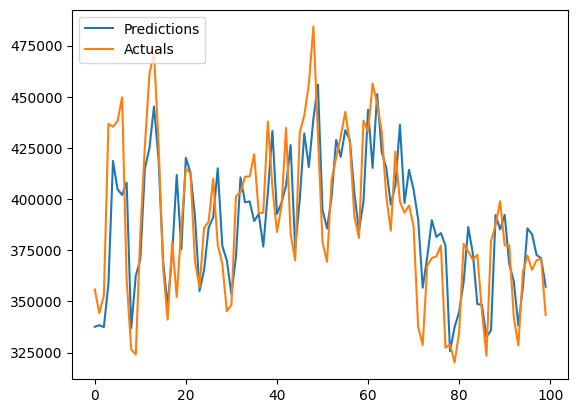

MAPE: 3.94%
RMSE: 20536.86
MAE : 15262.44


Predictions    Actuals
0    337604.15625  355814.96
1    338348.53125  344216.79
2    337439.78125  352812.68
3    358607.96875  436716.40
4    418637.28125  435360.14
..            ...        ...
719  381761.43750  353967.95
720  377941.65625  385900.00
721  394929.46875  411636.83
722  407117.09375  379656.38
723  368050.56250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model1 = load_model('model1.keras')

# print training metrics
predictions_plot(model1, X_train, y_train, 0, 100, preprocessor)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


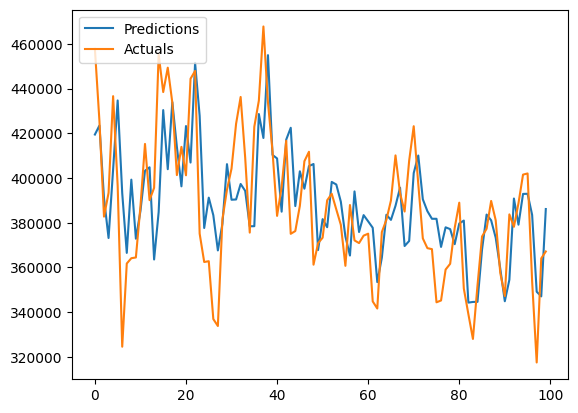

MAPE: 3.78%
RMSE: 18721.85
MAE : 14409.46


Predictions    Actuals
0    419461.56250  457780.70
1    423498.34375  425439.99
2    391016.18750  382741.80
3    373180.06250  393359.12
4    403874.56250  436628.85
..            ...        ...
353  384665.40625  405457.46
354  393431.09375  421027.63
355  381503.12500  407376.71
356  364519.75000  402263.51
357  367303.31250  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model1, X_val, y_val, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


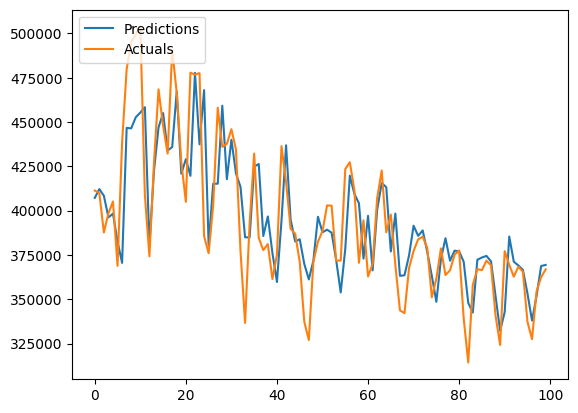

MAPE: 3.88%
RMSE: 19835.36
MAE : 14815.71


Predictions    Actuals
0    407204.15625  411339.27
1    412154.43750  409963.40
2    408381.59375  387672.63
3    396184.78125  398542.65
4    398320.12500  405159.36
..            ...        ...
353  367893.34375  360393.59
354  375173.00000  369325.03
355  359515.62500  371819.56
356  366619.59375  399427.25
357  380525.12500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model1, X_test, y_test, 0, 100)

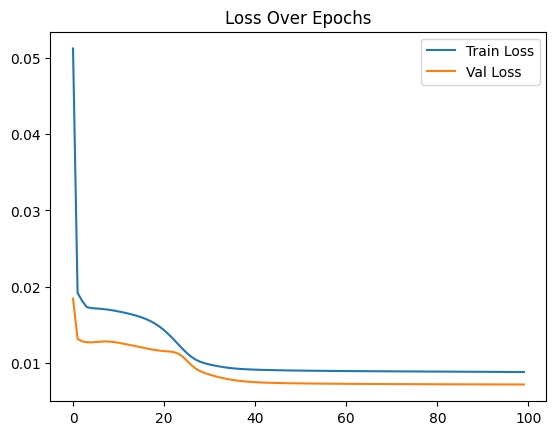

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history1.history['loss'], label='Train Loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 2 - Overlapping Windows ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(demandDF, window_size=7, allow_overlap=True)
preprocessor.split()
preprocessor.scale()
data2 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train2, y_train2 = data2['train']
X_val2, y_val2 = data2['val']
X_test2, y_test2 = data2['test']

# Initialise variables for input layer
i = X_train2.shape[1]
j = X_train2.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model2 = create_lstm_model()

# create model checkpoint
cp2 = ModelCheckpoint('model2.keras', save_best_only=True)

# compile model
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=100, callbacks=[cp2, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1006 - root_mean_squared_error: 0.3079 - val_loss: 0.0142 - val_root_mean_squared_error: 0.1194
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1178
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0184 - root_mean_squared_error: 0.1354 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1128
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1132
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


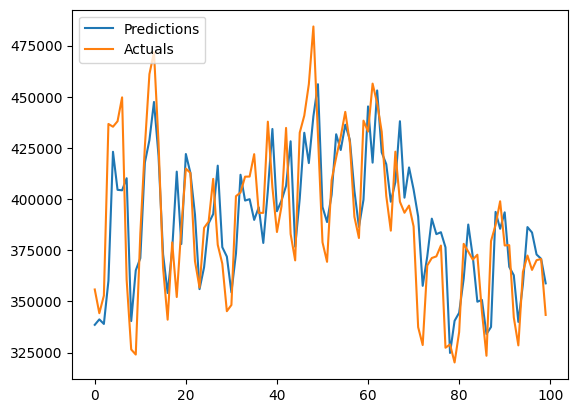

MAPE: 4.00%
RMSE: 20645.34
MAE : 15416.68


Predictions    Actuals
0    338534.50000  355814.96
1    341198.25000  344216.79
2    338962.21875  352812.68
3    360016.65625  436716.40
4    423124.50000  435360.14
..            ...        ...
719  381779.40625  353967.95
720  378159.46875  385900.00
721  397318.25000  411636.83
722  407387.56250  379656.38
723  364000.21875  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model2 = load_model('model2.keras')

# print training metrics
predictions_plot(model2, X_train2, y_train2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


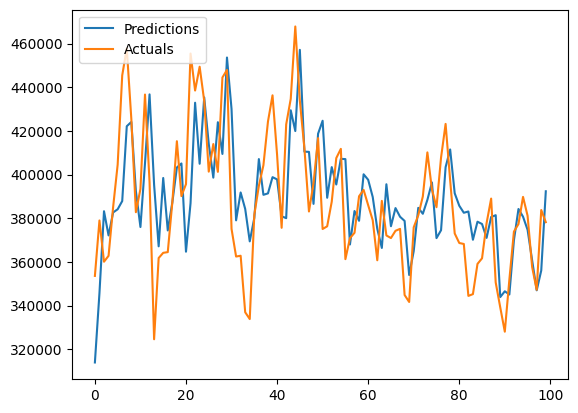

MAPE: 3.88%
RMSE: 19101.79
MAE : 14756.45


Predictions    Actuals
0    313928.03125  353567.49
1    345645.87500  378965.84
2    383192.09375  360065.93
3    372108.00000  362772.07
4    382621.18750  385022.79
..            ...        ...
360  385199.93750  405457.46
361  395485.40625  421027.63
362  384389.43750  407376.71
363  366205.46875  402263.51
364  370686.50000  405023.08

[365 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model2, X_val2, y_val2, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


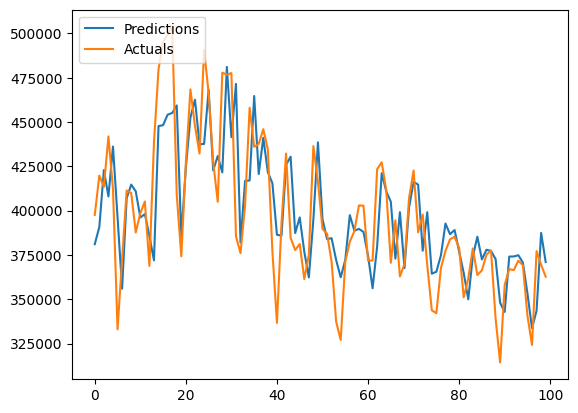

MAPE: 4.02%
RMSE: 20325.63
MAE : 15298.23


Predictions    Actuals
0    381079.62500  397576.81
1    390762.87500  419793.03
2    422880.53125  413402.43
3    408008.12500  441857.98
4    436174.62500  412076.90
..            ...        ...
360  367925.81250  360393.59
361  374345.21875  369325.03
362  361498.59375  371819.56
363  366822.06250  399427.25
364  382395.71875  408178.89

[365 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model2, X_test2, y_test2, 0, 100)

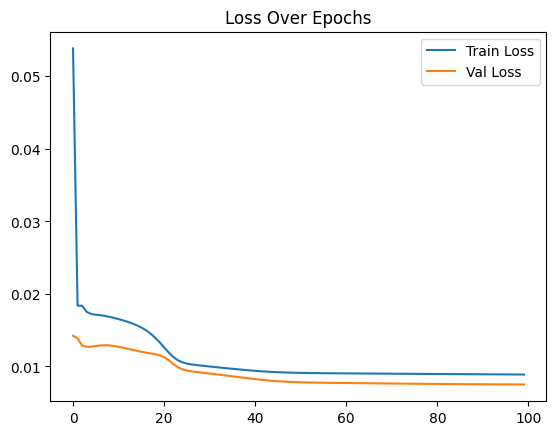

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 2. Introducing Temperature... ##

In [ ]:
# Add average temperature to features
tempDemandDF = test_df[['sum_30_min_demand', 'avg_temp']]

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data3 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train3, y_train3 = data3['train']
X_val3, y_val3 = data3['val']
X_test3, y_test3 = data3['test']

# Initialise variables for input layer
i = X_train3.shape[1]
j = X_train3.shape[2]

### Model 3 ###

In [ ]:
# set seed
reset_seed()

# create model
model3 = create_lstm_model()

# create model checkpoint
cp3 = ModelCheckpoint('model3.keras', save_best_only=True)

# compile model
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=100, callbacks=[cp3, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1722 - root_mean_squared_error: 0.4024 - val_loss: 0.0167 - val_root_mean_squared_error: 0.1291
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0196 - root_mean_squared_error: 0.1399 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1201
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0186 - root_mean_squared_error: 0.1363 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0171 - root_mean_squared_error: 0.1307 - val_loss: 0.0133 - val_root_mean_squared_error: 0.1154
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


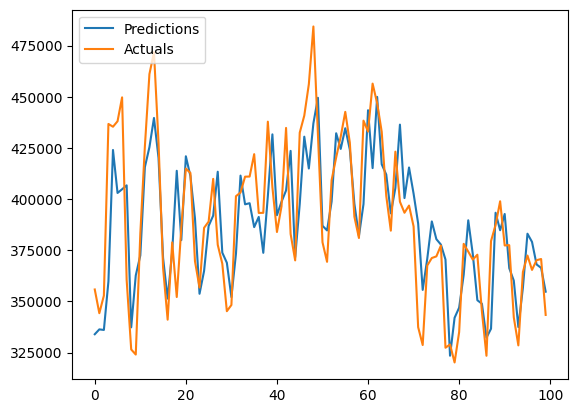

MAPE: 3.88%
RMSE: 20347.03
MAE : 15016.13


Predictions    Actuals
0    333931.15625  355814.96
1    336311.43750  344216.79
2    336032.96875  352812.68
3    359791.62500  436716.40
4    423995.65625  435360.14
..            ...        ...
719  381603.78125  353967.95
720  382570.43750  385900.00
721  400245.34375  411636.83
722  409419.12500  379656.38
723  367902.56250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model3 = load_model('model3.keras')

# print training metrics
predictions_plot(model3, X_train3, y_train3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


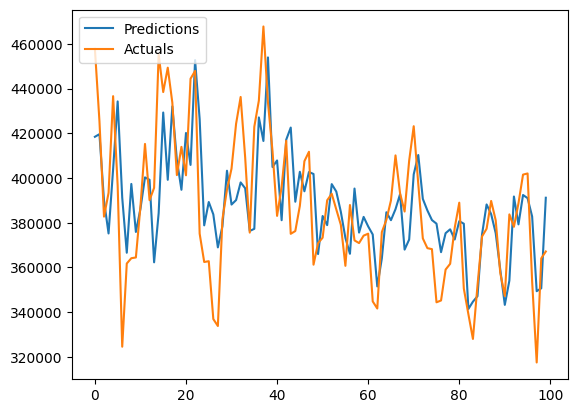

MAPE: 3.75%
RMSE: 18582.11
MAE : 14300.44


Predictions    Actuals
0    418454.34375  457780.70
1    419636.00000  425439.99
2    389903.56250  382741.80
3    375212.81250  393359.12
4    403965.71875  436628.85
..            ...        ...
353  385288.87500  405457.46
354  400646.09375  421027.63
355  391878.78125  407376.71
356  374229.84375  402263.51
357  374452.43750  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model3, X_val3, y_val3, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


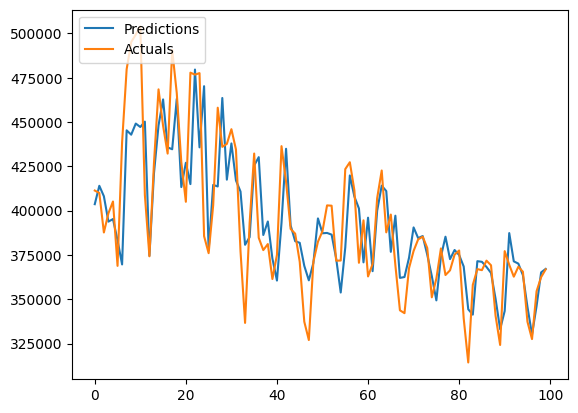

MAPE: 3.91%
RMSE: 20158.42
MAE : 14911.17


Predictions    Actuals
0    403639.31250  411339.27
1    414014.34375  409963.40
2    408116.81250  387672.63
3    393797.15625  398542.65
4    395265.37500  405159.36
..            ...        ...
353  370514.06250  360393.59
354  380443.84375  369325.03
355  372350.53125  371819.56
356  376220.59375  399427.25
357  388634.56250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model3, X_test3, y_test3, 0, 100)

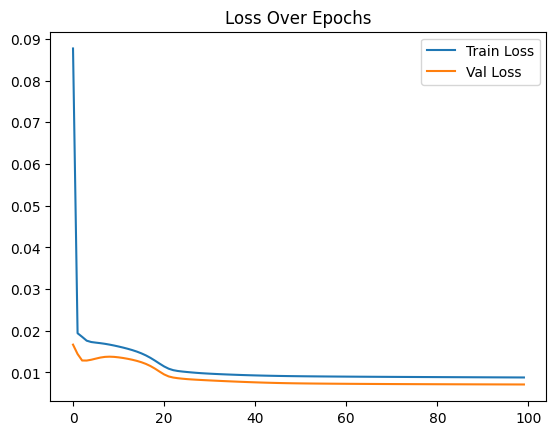

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history3.history['loss'], label='Train Loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 3. Testing Temp Measures ##

In [ ]:
# Add Min and Max Temp to features
tempDemandDF2 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp']]

### Model 4 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data4 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train4, y_train4 = data4['train']
X_val4, y_val4 = data4['val']
X_test4, y_test4 = data4['test']

# Initialise variables for input layer
i = X_train4.shape[1]
j = X_train4.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model4 = create_lstm_model()

# create model checkpoint
cp4 = ModelCheckpoint('model4.keras', save_best_only=True)

# compile model
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history4 = model4.fit(X_train4, y_train4, validation_data=(X_val4, y_val4), epochs=100, callbacks=[cp4, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1472 - root_mean_squared_error: 0.3722 - val_loss: 0.0260 - val_root_mean_squared_error: 0.1613
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0245 - root_mean_squared_error: 0.1561 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0171 - root_mean_squared_error: 0.1306 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - root_mean_squared_error: 0.1311 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1168
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0166 - root_mean_squared_error: 0.1289 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1139
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


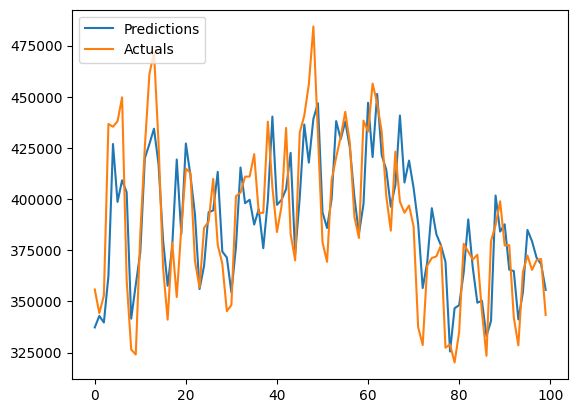

MAPE: 4.03%
RMSE: 20646.36
MAE : 15484.72


Predictions    Actuals
0    337259.40625  355814.96
1    342896.93750  344216.79
2    339665.81250  352812.68
3    362443.18750  436716.40
4    426929.87500  435360.14
..            ...        ...
719  378976.06250  353967.95
720  389286.43750  385900.00
721  398294.34375  411636.83
722  397648.12500  379656.38
723  354863.09375  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model4 = load_model('model4.keras')

# print training metrics
predictions_plot(model4, X_train4, y_train4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


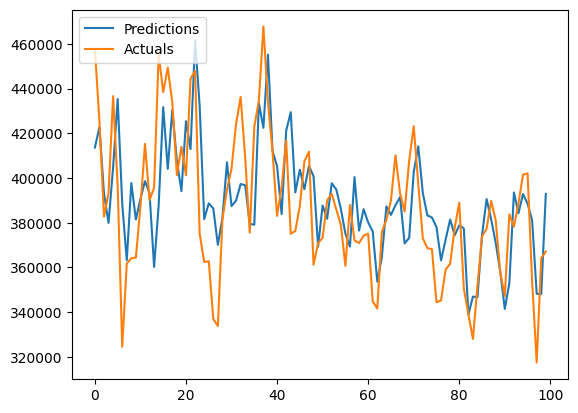

MAPE: 3.93%
RMSE: 19131.72
MAE : 14890.63


Predictions    Actuals
0    413658.06250  457780.70
1    422743.59375  425439.99
2    393023.93750  382741.80
3    379936.40625  393359.12
4    404825.15625  436628.85
..            ...        ...
353  384506.15625  405457.46
354  398236.96875  421027.63
355  387527.18750  407376.71
356  372116.46875  402263.51
357  375028.75000  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model4, X_val4, y_val4, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


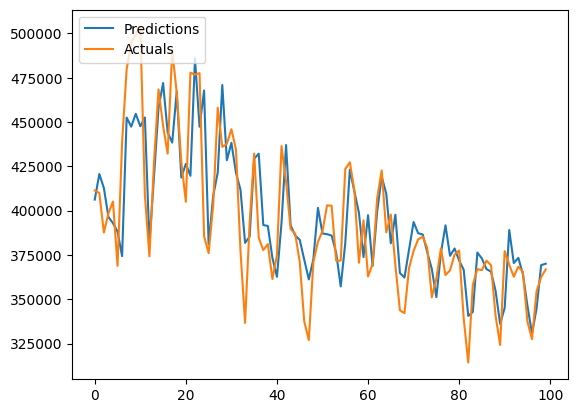

MAPE: 4.07%
RMSE: 20357.72
MAE : 15439.46


Predictions    Actuals
0    406237.25000  411339.27
1    420665.18750  409963.40
2    412763.78125  387672.63
3    396434.53125  398542.65
4    392919.12500  405159.36
..            ...        ...
353  371225.40625  360393.59
354  376527.34375  369325.03
355  369287.87500  371819.56
356  368646.65625  399427.25
357  382756.37500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model4, X_test4, y_test4, 0, 100)

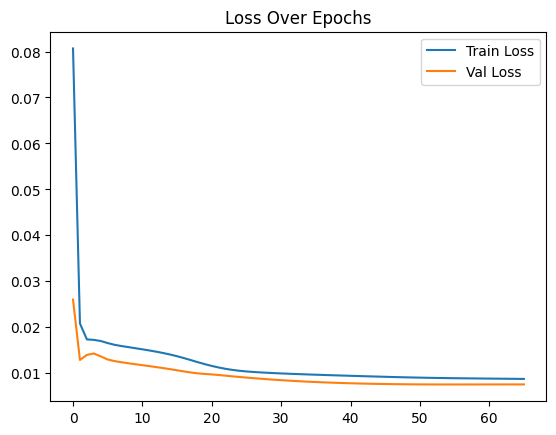

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history4.history['loss'], label='Train Loss')
plt.plot(history4.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 5 ###

In [ ]:
# create temp_range feature
test_df['temp_range'] = test_df['max_temp'] - test_df['min_temp']

# Add temperature range to features and drop min and max temperature
tempDemandDF3 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()
tempDemandDF3.drop(['min_temp', 'max_temp'], axis=1, inplace=True)

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF3, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data5 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train5, y_train5 = data5['train']
X_val5, y_val5 = data5['val']
X_test5, y_test5 = data5['test']

# Initialise variables for input layer
i = X_train5.shape[1]
j = X_train5.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model5 = create_lstm_model()

# create model checkpoint
cp5 = ModelCheckpoint('model5.keras', save_best_only=True)

# compile model
model5.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history5 = model5.fit(X_train5, y_train5, validation_data=(X_val5, y_val5), epochs=100, callbacks=[cp5, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.1555 - root_mean_squared_error: 0.3816 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1315
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0230 - root_mean_squared_error: 0.1515 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0175 - root_mean_squared_error: 0.1322 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1218
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1200
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0169 - root_mean_squared_error: 0.1299 - val_loss: 0.0139 - val_root_mean_squared_error: 0.1181
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


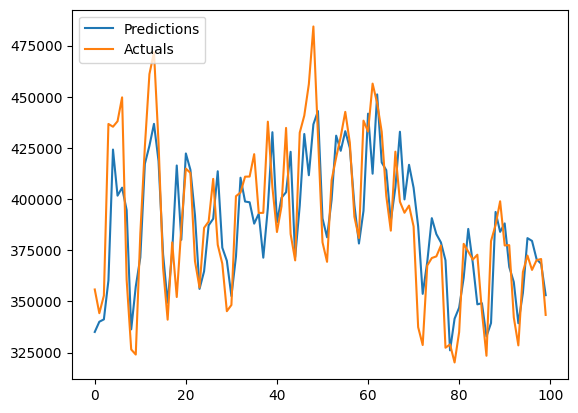

MAPE: 3.84%
RMSE: 20094.64
MAE : 14885.44


Predictions    Actuals
0    335052.00000  355814.96
1    340041.93750  344216.79
2    341199.31250  352812.68
3    360207.15625  436716.40
4    424202.56250  435360.14
..            ...        ...
719  376773.28125  353967.95
720  384869.09375  385900.00
721  398307.50000  411636.83
722  404984.09375  379656.38
723  363104.81250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model5 = load_model('model5.keras')

# print training metrics
predictions_plot(model5, X_train5, y_train5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


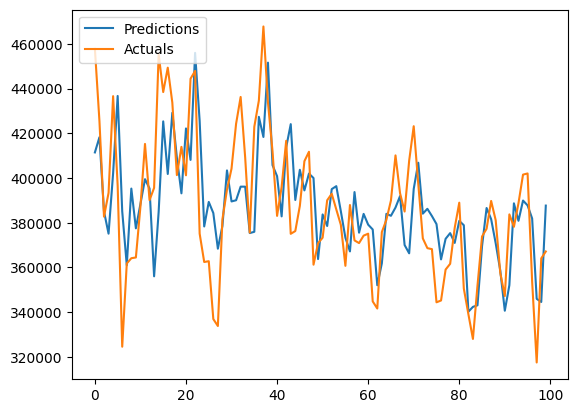

MAPE: 3.74%
RMSE: 18621.36
MAE : 14305.19


Predictions    Actuals
0    411461.43750  457780.70
1    418269.43750  425439.99
2    385034.78125  382741.80
3    375128.90625  393359.12
4    402136.87500  436628.85
..            ...        ...
353  383721.31250  405457.46
354  398440.12500  421027.63
355  386906.09375  407376.71
356  366949.62500  402263.51
357  366906.62500  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model5, X_val5, y_val5, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


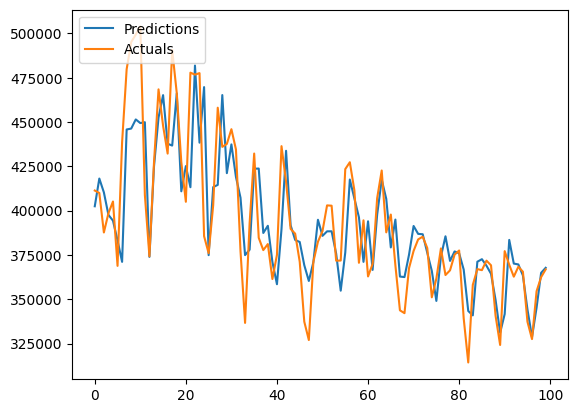

MAPE: 3.84%
RMSE: 19829.26
MAE : 14700.98


Predictions    Actuals
0    402458.09375  411339.27
1    418103.31250  409963.40
2    410288.21875  387672.63
3    397617.62500  398542.65
4    394334.56250  405159.36
..            ...        ...
353  367932.25000  360393.59
354  377505.03125  369325.03
355  368858.75000  371819.56
356  371809.25000  399427.25
357  384476.59375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model5, X_test5, y_test5, 0, 100)

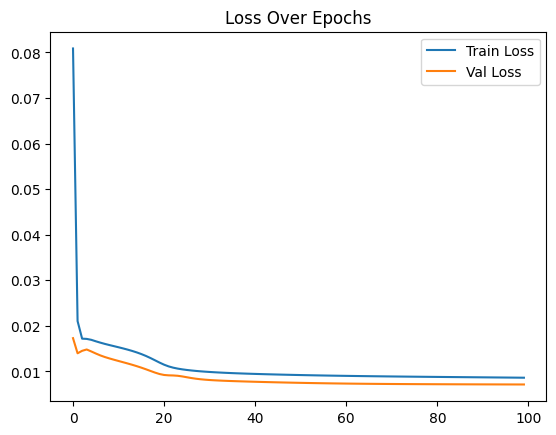

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history5.history['loss'], label='Train Loss')
plt.plot(history5.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 6 ###

In [ ]:
# Add min and max temperature back into features
tempDemandDF4 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data6 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train6, y_train6 = data6['train']
X_val6, y_val6 = data6['val']
X_test6, y_test6 = data6['test']

# Initialise variables for input layer
i = X_train6.shape[1]
j = X_train6.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model6 = create_lstm_model()

# create model checkpoint
cp6 = ModelCheckpoint('model6.keras', save_best_only=True)

# compile model
model6.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history6 = model6.fit(X_train6, y_train6, validation_data=(X_val6, y_val6), epochs=100, callbacks=[cp6, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1797 - root_mean_squared_error: 0.4094 - val_loss: 0.0230 - val_root_mean_squared_error: 0.1517
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0239 - root_mean_squared_error: 0.1542 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1138
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - root_mean_squared_error: 0.1312 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1183
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0173 - root_mean_squared_error: 0.1315 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1185
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0170 - root_mean_squared_error: 0.1302 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1148
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1278 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1133
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - lo

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


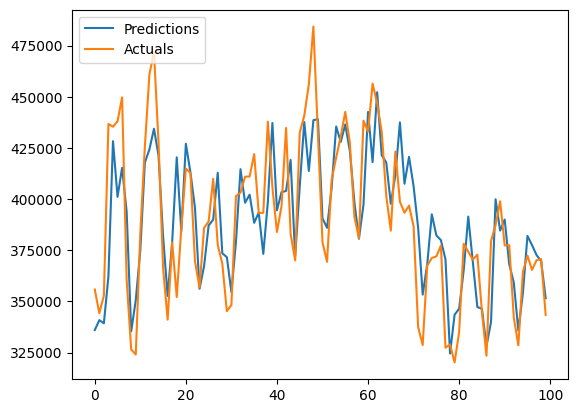

MAPE: 3.81%
RMSE: 19750.49
MAE : 14669.21


Predictions    Actuals
0    335970.12500  355814.96
1    340818.40625  344216.79
2    339300.90625  352812.68
3    362299.15625  436716.40
4    428307.28125  435360.14
..            ...        ...
719  377808.09375  353967.95
720  387943.12500  385900.00
721  397867.31250  411636.83
722  401806.81250  379656.38
723  357333.50000  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model6 = load_model('model6.keras')

# print training metrics
predictions_plot(model6, X_train6, y_train6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


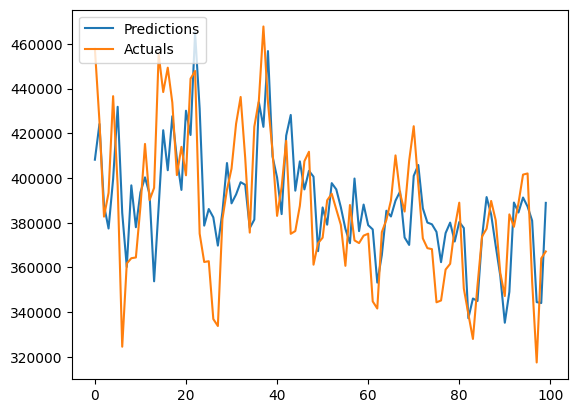

MAPE: 3.79%
RMSE: 18651.60
MAE : 14401.41


Predictions    Actuals
0    408211.46875  457780.70
1    424165.00000  425439.99
2    387831.34375  382741.80
3    377428.21875  393359.12
4    399516.50000  436628.85
..            ...        ...
353  385819.46875  405457.46
354  401172.62500  421027.63
355  388524.12500  407376.71
356  369179.18750  402263.51
357  370604.43750  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model6, X_val6, y_val6, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


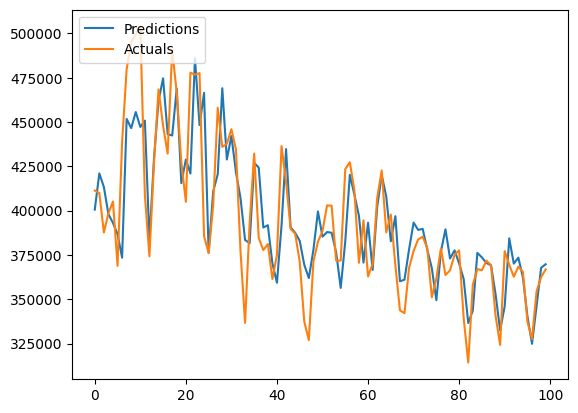

MAPE: 3.88%
RMSE: 19642.82
MAE : 14757.63


Predictions    Actuals
0    400561.37500  411339.27
1    421003.25000  409963.40
2    413328.31250  387672.63
3    398009.18750  398542.65
4    393058.09375  405159.36
..            ...        ...
353  372959.90625  360393.59
354  377627.21875  369325.03
355  370034.03125  371819.56
356  370727.59375  399427.25
357  381877.31250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model6, X_test6, y_test6, 0, 100)

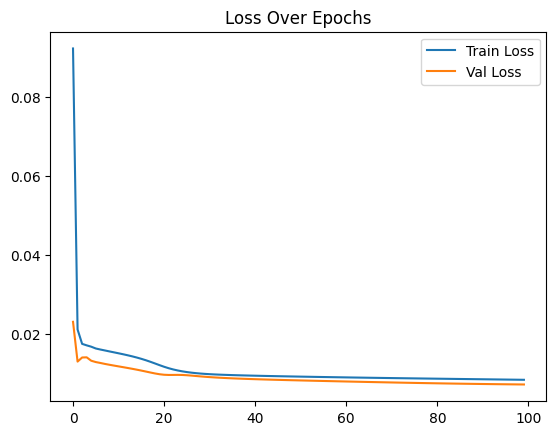

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history6.history['loss'], label='Train Loss')
plt.plot(history6.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 7 - Increase Window Size to 10 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=10, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data7 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train7, y_train7 = data7['train']
X_val7, y_val7 = data7['val']
X_test7, y_test7 = data7['test']

# Initialise variables for input layer
i = X_train7.shape[1]
j = X_train7.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model7 = create_lstm_model()

# create model checkpoint
cp7 = ModelCheckpoint('model7.keras', save_best_only=True)

# compile model
model7.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history7 = model7.fit(X_train7, y_train7, validation_data=(X_val7, y_val7), epochs=100, callbacks=[cp7, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.1791 - root_mean_squared_error: 0.4084 - val_loss: 0.0273 - val_root_mean_squared_error: 0.1654
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0253 - root_mean_squared_error: 0.1588 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1176
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - root_mean_squared_error: 0.1402 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1135
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0176 - root_mean_squared_error: 0.1324 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1136
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0168 - root_mean_squared_error: 0.1296 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1134
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - root_mean_squared_error: 0.1278 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1121
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


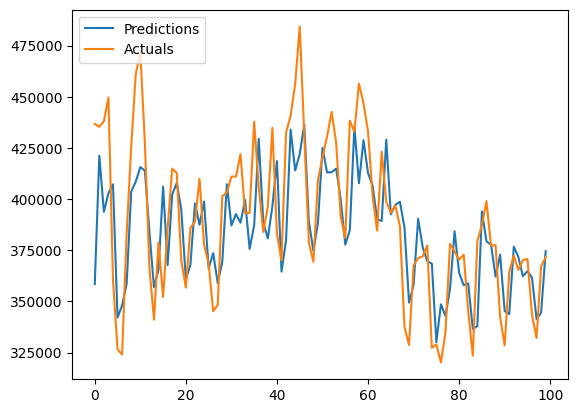

MAPE: 4.36%
RMSE: 22198.37
MAE : 16965.79


Predictions    Actuals
0    358428.59375  436716.40
1    421172.03125  435360.14
2    393773.25000  438032.58
3    402871.00000  449709.69
4    407260.62500  360495.64
..            ...        ...
716  366752.93750  353967.95
717  389462.50000  385900.00
718  390353.28125  411636.83
719  390766.06250  379656.38
720  354504.40625  342930.54

[721 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model7 = load_model('model7.keras')

# print training metrics
predictions_plot(model7, X_train7, y_train7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


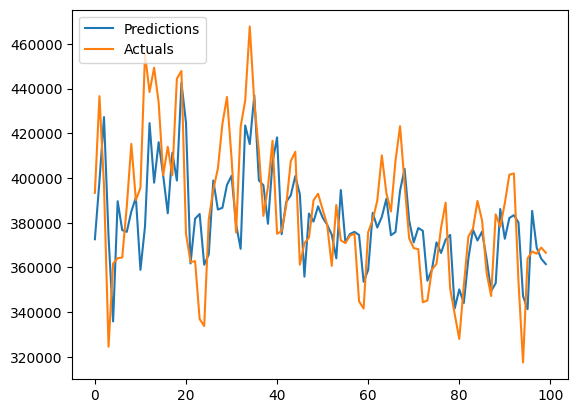

MAPE: 4.01%
RMSE: 19575.57
MAE : 15336.93


Predictions    Actuals
0    372626.28125  393359.12
1    398657.68750  436628.85
2    427272.56250  396547.46
3    373639.12500  324557.19
4    335855.59375  361764.59
..            ...        ...
350  372341.84375  405457.46
351  397148.18750  421027.63
352  389428.00000  407376.71
353  372422.53125  402263.51
354  375484.28125  405023.08

[355 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model7, X_val7, y_val7, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


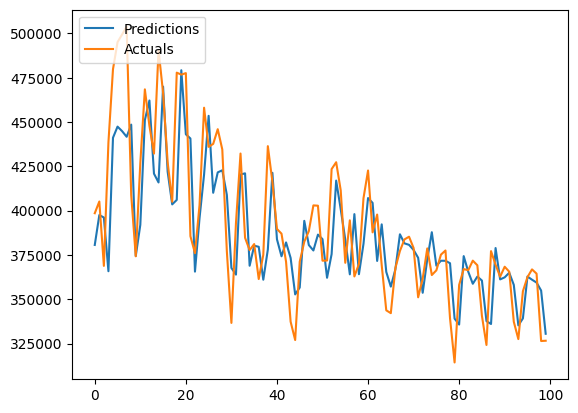

MAPE: 4.31%
RMSE: 21372.01
MAE : 16535.65


Predictions    Actuals
0    380648.81250  398542.65
1    397498.12500  405159.36
2    396122.90625  368840.45
3    365822.12500  438517.06
4    441112.68750  479784.41
..            ...        ...
350  360183.34375  360393.59
351  372562.34375  369325.03
352  368311.31250  371819.56
353  365222.21875  399427.25
354  386056.71875  408178.89

[355 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model7, X_test7, y_test7, 0, 100)

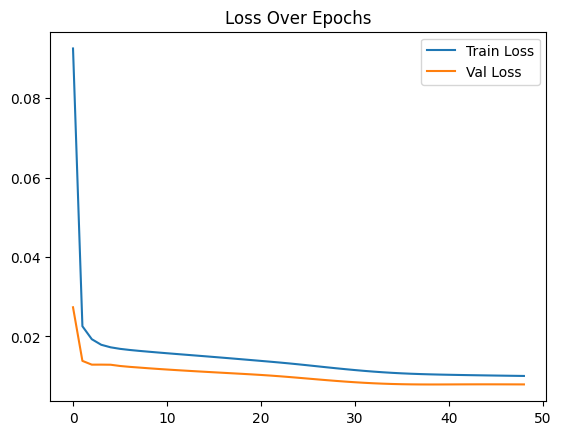

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history7.history['loss'], label='Train Loss')
plt.plot(history7.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 8 - Decrease Window Size to 5 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=5, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data8 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train8, y_train8 = data8['train']
X_val8, y_val8 = data8['val']
X_test8, y_test8 = data8['test']

# Initialise variables for input layer
i = X_train8.shape[1]
j = X_train8.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model8 = create_lstm_model()

# create model checkpoint
cp8 = ModelCheckpoint('model8.keras', save_best_only=True)

# compile model
model8.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history8 = model8.fit(X_train8, y_train8, validation_data=(X_val8, y_val8), epochs=100, callbacks=[cp8, es1])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1737 - root_mean_squared_error: 0.4058 - val_loss: 0.0220 - val_root_mean_squared_error: 0.1484
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0266 - root_mean_squared_error: 0.1630 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0193 - root_mean_squared_error: 0.1388 - val_loss: 0.0132 - val_root_mean_squared_error: 0.1147
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0179 - root_mean_squared_error: 0.1337 - val_loss: 0.0131 - val_root_mean_squared_error: 0.1147
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0172 - root_mean_squared_error: 0.1309 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1140
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0128 - val_root_mean_squared_error: 0.1129
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


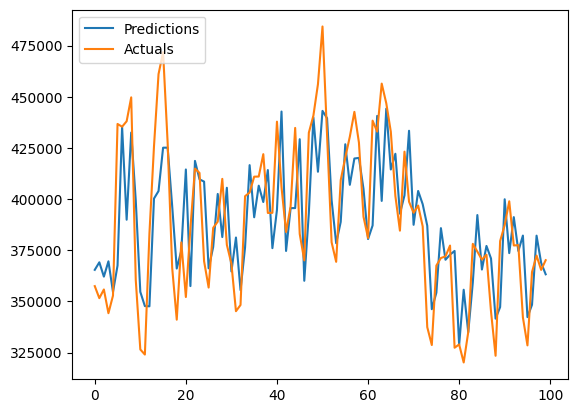

MAPE: 4.33%
RMSE: 21901.51
MAE : 16634.85


Predictions    Actuals
0    365407.75000  357451.06
1    369092.09375  351570.67
2    362099.59375  355814.96
3    369579.28125  344216.79
4    354582.03125  352812.68
..            ...        ...
721  355500.00000  353967.95
722  376429.71875  385900.00
723  390710.15625  411636.83
724  403810.71875  379656.38
725  358735.12500  342930.54

[726 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model8 = load_model('model8.keras')

# print training metrics
predictions_plot(model8, X_train8, y_train8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


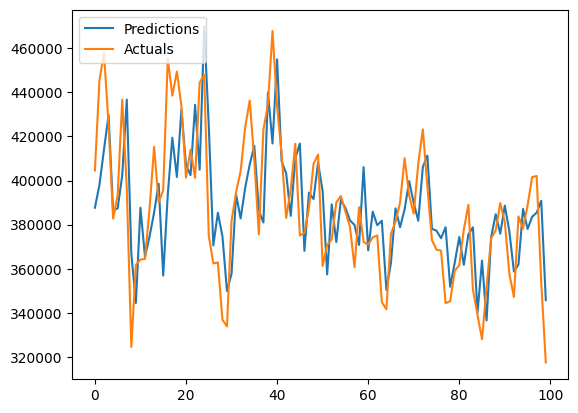

MAPE: 4.10%
RMSE: 19656.12
MAE : 15560.37


Predictions    Actuals
0    387649.00000  404557.93
1    398004.31250  445401.38
2    414060.18750  457780.70
3    429752.18750  425439.99
4    386340.65625  382741.80
..            ...        ...
355  373446.34375  405457.46
356  396861.12500  421027.63
357  395573.15625  407376.71
358  383391.90625  402263.51
359  387092.84375  405023.08

[360 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model8, X_val8, y_val8, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


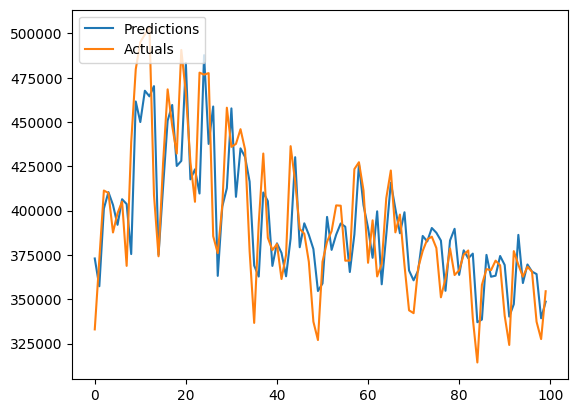

MAPE: 4.22%
RMSE: 20711.86
MAE : 15901.81


Predictions    Actuals
0    373017.31250  333009.61
1    357341.96875  372457.04
2    401183.34375  411339.27
3    410445.34375  409963.40
4    403227.43750  387672.63
..            ...        ...
355  371450.40625  360393.59
356  373427.03125  369325.03
357  375005.56250  371819.56
358  374088.31250  399427.25
359  397706.00000  408178.89

[360 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model8, X_test8, y_test8, 0, 100)

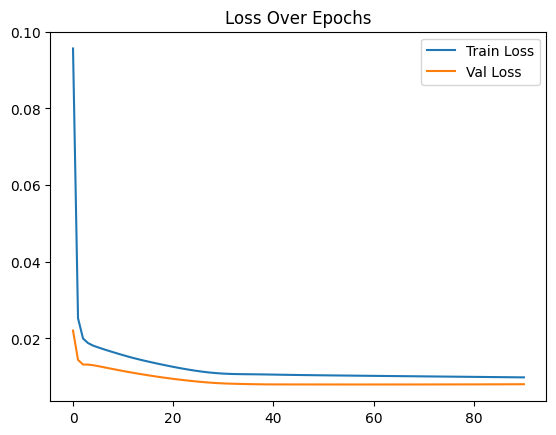

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history8.history['loss'], label='Train Loss')
plt.plot(history8.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 9 - Increase Window Size to 14 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF4, window_size=14, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data9 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train9, y_train9 = data9['train']
X_val9, y_val9 = data9['val']
X_test9, y_test9 = data9['test']

# Initialise variables for input layer
i = X_train9.shape[1]
j = X_train9.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model9 = create_lstm_model()

# create model checkpoint
cp9 = ModelCheckpoint('model9.keras', save_best_only=True)

# compile model
model9.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history9 = model9.fit(X_train9, y_train9, validation_data=(X_val9, y_val9), epochs=100, callbacks=[cp9, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1865 - root_mean_squared_error: 0.4162 - val_loss: 0.0215 - val_root_mean_squared_error: 0.1466
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0234 - root_mean_squared_error: 0.1528 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0195 - root_mean_squared_error: 0.1394 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0180 - root_mean_squared_error: 0.1341 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0177 - root_mean_squared_error: 0.1328 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1102
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0174 - root_mean_squared_error: 0.1318 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1091
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


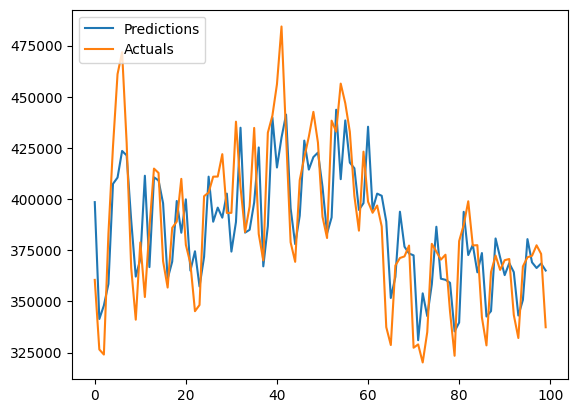

MAPE: 4.24%
RMSE: 21398.26
MAE : 16342.18


Predictions    Actuals
0    398502.90625  360495.64
1    341374.65625  326492.10
2    347980.43750  324006.75
3    358521.15625  383092.64
4    407436.84375  425665.84
..            ...        ...
712  368271.46875  353967.95
713  388883.31250  385900.00
714  393075.93750  411636.83
715  396772.50000  379656.38
716  356351.00000  342930.54

[717 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model9 = load_model('model9.keras')

# print training metrics
predictions_plot(model9, X_train9, y_train9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


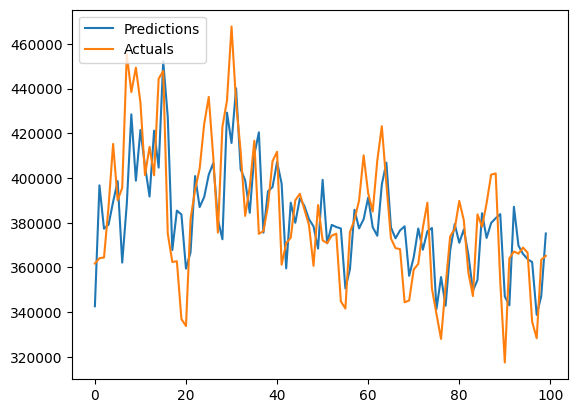

MAPE: 3.91%
RMSE: 18855.12
MAE : 14854.93


Predictions    Actuals
0    342650.09375  361764.59
1    396733.03125  364142.94
2    377337.00000  364469.53
3    379173.00000  387246.97
4    389341.09375  415263.41
..            ...        ...
346  373960.46875  405457.46
347  395908.90625  421027.63
348  389039.62500  407376.71
349  373138.68750  402263.51
350  377186.71875  405023.08

[351 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model9, X_val9, y_val9, 0, 100)

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


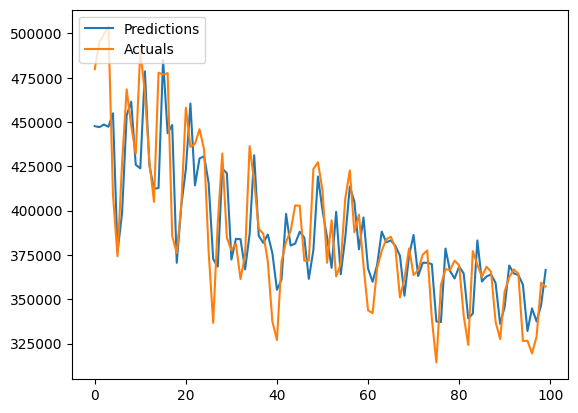

MAPE: 4.16%
RMSE: 20376.72
MAE : 15773.96


Predictions    Actuals
0    447667.96875  479784.41
1    447078.18750  495056.95
2    448544.65625  499342.29
3    447321.43750  503885.71
4    454912.81250  408832.77
..            ...        ...
346  365547.59375  360393.59
347  374197.15625  369325.03
348  368655.53125  371819.56
349  365515.90625  399427.25
350  386250.25000  408178.89

[351 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model9, X_test9, y_test9, 0, 100)

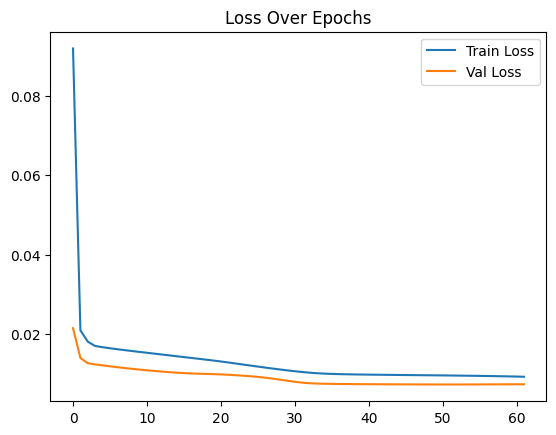

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history9.history['loss'], label='Train Loss')
plt.plot(history9.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 10 - Add CDD/HDD ###

In [ ]:
# Add cooling degree days and heating degree days into feature set
tempDemandDF5 = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF5, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data10 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train10, y_train10 = data10['train']
X_val10, y_val10 = data10['val']
X_test10, y_test10 = data10['test']

# Initialise variables for input layer
i = X_train10.shape[1]
j = X_train10.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model10 = create_lstm_model()

# create model checkpoint
cp10 = ModelCheckpoint('model10.keras', save_best_only=True)

# compile model
model10.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history10 = model10.fit(X_train10, y_train10, validation_data=(X_val10, y_val10), epochs=100, callbacks=[cp10, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1302 - root_mean_squared_error: 0.3493 - val_loss: 0.0166 - val_root_mean_squared_error: 0.1289
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0211 - root_mean_squared_error: 0.1451 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1284 - val_loss: 0.0144 - val_root_mean_squared_error: 0.1199
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1174
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0157 - root_mean_squared_error: 0.1254 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1127
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1114
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - l

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


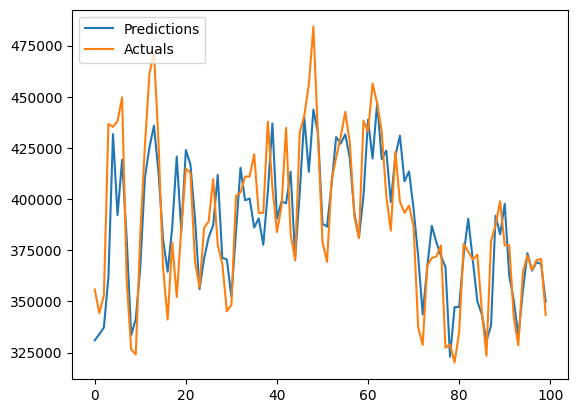

MAPE: 3.52%
RMSE: 18783.68
MAE : 13574.66


Predictions    Actuals
0    330947.09375  355814.96
1    334005.96875  344216.79
2    337214.53125  352812.68
3    361966.09375  436716.40
4    431763.90625  435360.14
..            ...        ...
719  378818.68750  353967.95
720  390952.75000  385900.00
721  395349.68750  411636.83
722  393282.50000  379656.38
723  350355.78125  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model10 = load_model('model10.keras')

# print training metrics
predictions_plot(model10, X_train10, y_train10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


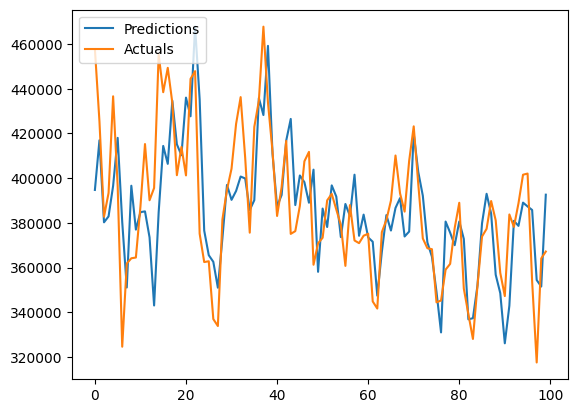

MAPE: 3.64%
RMSE: 18298.75
MAE : 13915.70


Predictions    Actuals
0    394721.18750  457780.70
1    416954.09375  425439.99
2    380229.46875  382741.80
3    382876.18750  393359.12
4    396533.84375  436628.85
..            ...        ...
353  383044.78125  405457.46
354  396981.68750  421027.63
355  396945.50000  407376.71
356  373200.78125  402263.51
357  369484.43750  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model10, X_val10, y_val10, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


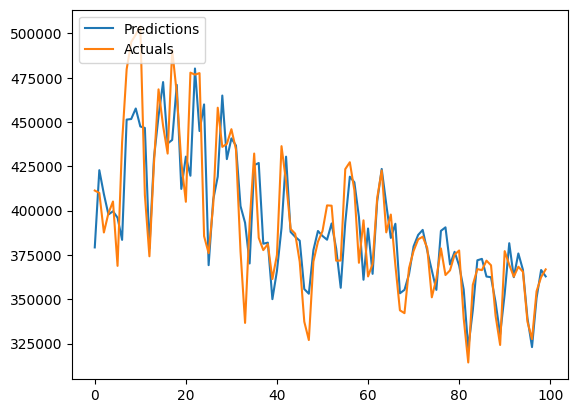

MAPE: 3.86%
RMSE: 19571.43
MAE : 14682.51


Predictions    Actuals
0    379252.25000  411339.27
1    422819.46875  409963.40
2    409350.53125  387672.63
3    397824.15625  398542.65
4    399643.31250  405159.36
..            ...        ...
353  381414.71875  360393.59
354  381131.62500  369325.03
355  383195.90625  371819.56
356  378972.34375  399427.25
357  368775.65625  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model10, X_test10, y_test10, 0, 100)

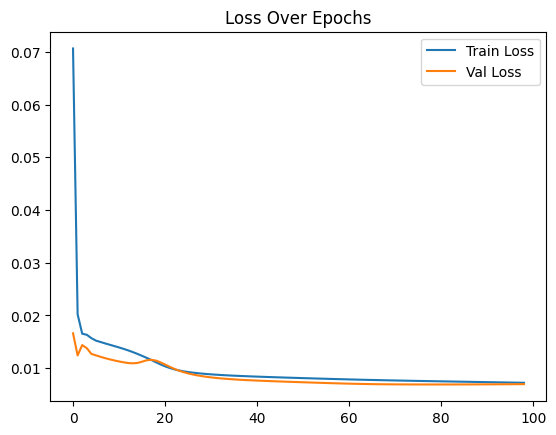

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history10.history['loss'], label='Train Loss')
plt.plot(history10.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 11 - Remove Avg Temp from Model 10 ###

In [ ]:
# Remove average temperature
tempDemandDF6 = test_df[['sum_30_min_demand', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempDemandDF6, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data11 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train11, y_train11 = data11['train']
X_val11, y_val11 = data11['val']
X_test11, y_test11 = data11['test']

# Initialise variables for input layer
i = X_train11.shape[1]
j = X_train11.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model11 = create_lstm_model()

# create model checkpoint
cp11 = ModelCheckpoint('model11.keras', save_best_only=True)

# compile model
model11.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history11 = model11.fit(X_train11, y_train11, validation_data=(X_val11, y_val11), epochs=100, callbacks=[cp11, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1362 - root_mean_squared_error: 0.3570 - val_loss: 0.0180 - val_root_mean_squared_error: 0.1340
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0224 - root_mean_squared_error: 0.1496 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1157
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0145 - val_root_mean_squared_error: 0.1205
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - root_mean_squared_error: 0.1285 - val_loss: 0.0146 - val_root_mean_squared_error: 0.1210
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0160 - root_mean_squared_error: 0.1266 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - root_mean_squared_error: 0.1246 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


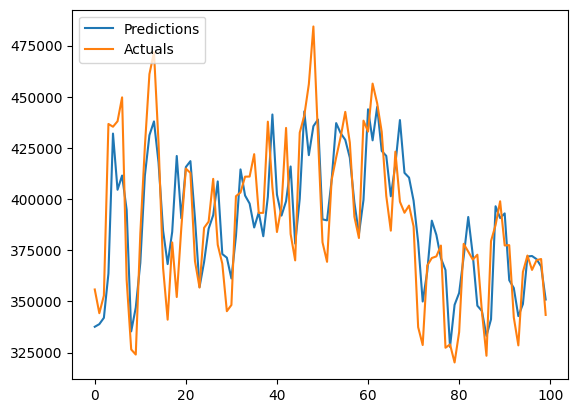

MAPE: 3.82%
RMSE: 19723.50
MAE : 14643.15


Predictions    Actuals
0    337583.75000  355814.96
1    338866.59375  344216.79
2    341956.62500  352812.68
3    363608.15625  436716.40
4    432015.09375  435360.14
..            ...        ...
719  376761.53125  353967.95
720  394306.59375  385900.00
721  396645.25000  411636.83
722  394507.68750  379656.38
723  354853.40625  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model11 = load_model('model11.keras')

# print training metrics
predictions_plot(model11, X_train11, y_train11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


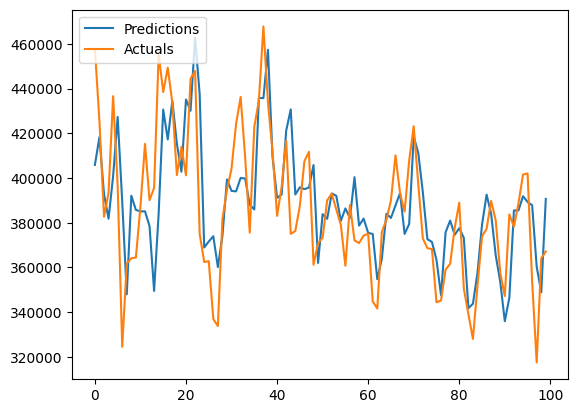

MAPE: 3.78%
RMSE: 18608.76
MAE : 14333.01


Predictions    Actuals
0    405879.46875  457780.70
1    418321.12500  425439.99
2    392829.06250  382741.80
3    381814.56250  393359.12
4    400819.40625  436628.85
..            ...        ...
353  381339.09375  405457.46
354  398173.21875  421027.63
355  401500.53125  407376.71
356  378124.65625  402263.51
357  372951.31250  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model11, X_val11, y_val11, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


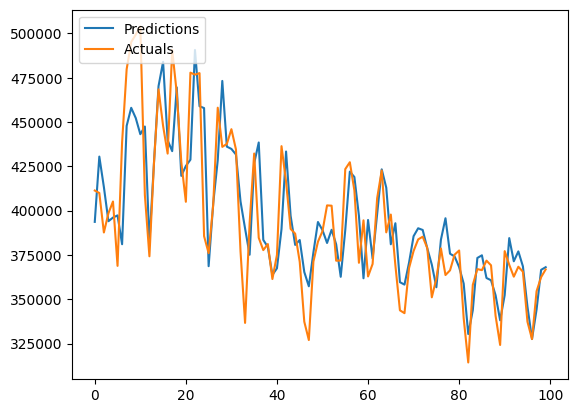

MAPE: 4.14%
RMSE: 20473.30
MAE : 15675.78


Predictions    Actuals
0    393662.15625  411339.27
1    430487.25000  409963.40
2    413323.71875  387672.63
3    394031.68750  398542.65
4    396078.43750  405159.36
..            ...        ...
353  374680.81250  360393.59
354  380780.18750  369325.03
355  380436.18750  371819.56
356  373103.03125  399427.25
357  377994.25000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model11, X_test11, y_test11, 0, 100)

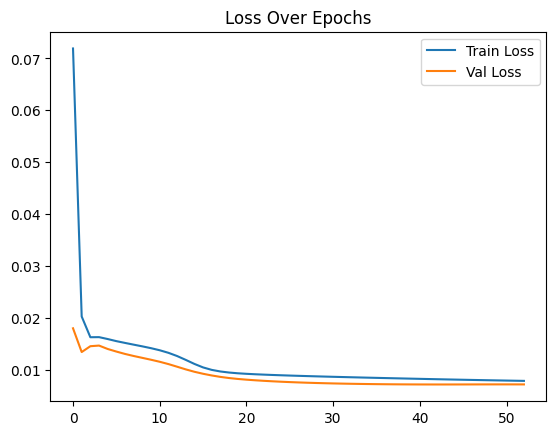

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history11.history['loss'], label='Train Loss')
plt.plot(history11.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 4. Introduce Other Weather Features ##

### Model 12 - Precipitation ###

In [ ]:
# Add average temperature back in due to poor last run without that feature
# Add precipitation feature
tempPrecipDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempPrecipDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data12 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

# Prepare splits for model run
X_train12, y_train12 = data12['train']
X_val12, y_val12 = data12['val']
X_test12, y_test12 = data12['test']

# Initialise variables for input layer
i = X_train12.shape[1]
j = X_train12.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model12 = create_lstm_model()

# create model checkpoint
cp12 = ModelCheckpoint('model12.keras', save_best_only=True)

# compile model
model12.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history12 = model12.fit(X_train12, y_train12, validation_data=(X_val12, y_val12), epochs=100, callbacks=[cp12, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 76ms/step - loss: 0.1577 - root_mean_squared_error: 0.3831 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0211 - root_mean_squared_error: 0.1450 - val_loss: 0.0126 - val_root_mean_squared_error: 0.1124
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0167 - root_mean_squared_error: 0.1291 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1164
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0164 - root_mean_squared_error: 0.1282 - val_loss: 0.0143 - val_root_mean_squared_error: 0.1195
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0162 - root_mean_squared_error: 0.1273 - val_loss: 0.0135 - val_root_mean_squared_error: 0.1161
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0127 - val_root_mean_squared_error: 0.1126
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


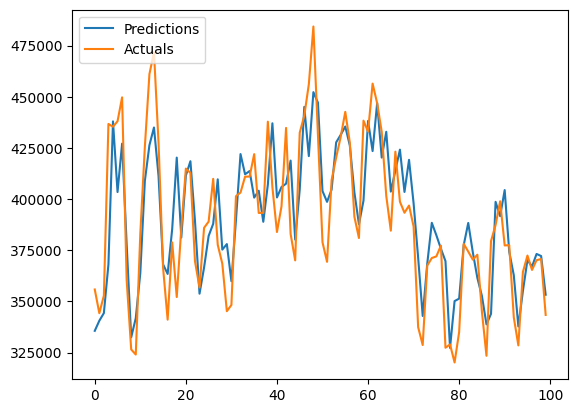

MAPE: 3.41%
RMSE: 17588.42
MAE : 13092.28


Predictions    Actuals
0    335596.53125  355814.96
1    340537.21875  344216.79
2    344280.81250  352812.68
3    368065.71875  436716.40
4    437967.75000  435360.14
..            ...        ...
719  386566.81250  353967.95
720  399005.75000  385900.00
721  407422.56250  411636.83
722  389788.15625  379656.38
723  356309.56250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model12 = load_model('model12.keras')

# print training metrics
predictions_plot(model12, X_train12, y_train12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


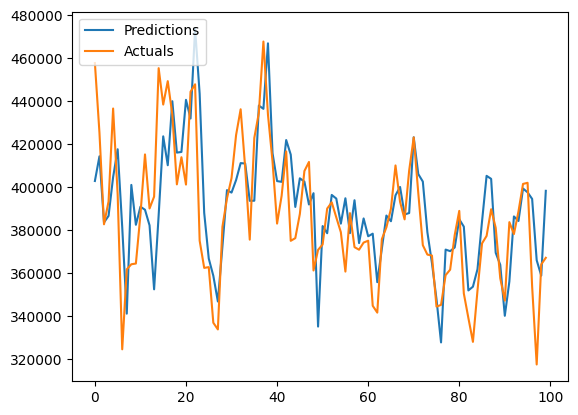

MAPE: 3.49%
RMSE: 17652.99
MAE : 13273.13


Predictions    Actuals
0    402892.37500  457780.70
1    414385.12500  425439.99
2    383602.71875  382741.80
3    386654.75000  393359.12
4    404676.65625  436628.85
..            ...        ...
353  387957.21875  405457.46
354  412405.90625  421027.63
355  416226.90625  407376.71
356  393952.03125  402263.51
357  383943.34375  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model12, X_val12, y_val12, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


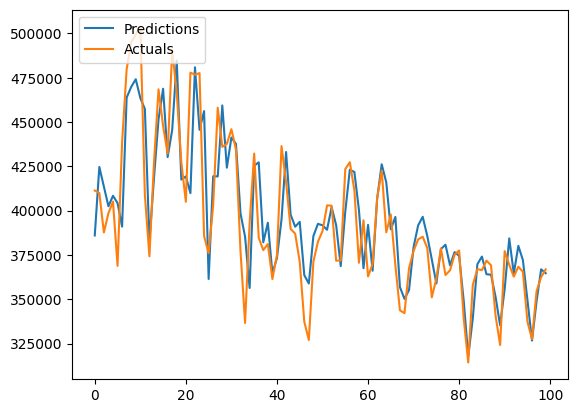

MAPE: 3.93%
RMSE: 19580.95
MAE : 14810.21


Predictions    Actuals
0    385996.78125  411339.27
1    424624.34375  409963.40
2    413584.21875  387672.63
3    402478.93750  398542.65
4    408387.15625  405159.36
..            ...        ...
353  391287.75000  360393.59
354  403710.65625  369325.03
355  405071.75000  371819.56
356  401366.28125  399427.25
357  378542.81250  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model12, X_test12, y_test12, 0, 100)

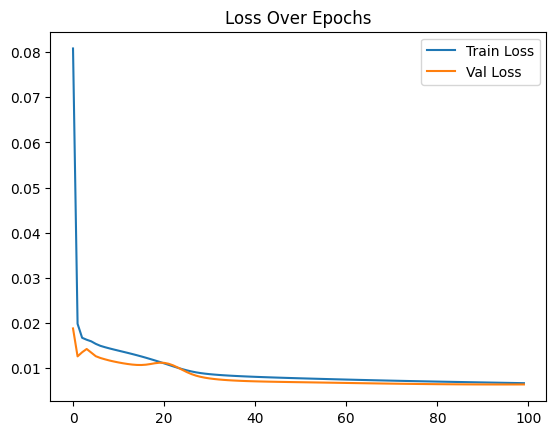

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history12.history['loss'], label='Train Loss')
plt.plot(history12.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 13 - Sunlight ###

In [ ]:
# Remove precipitation and add sunlight measurement
tempSunDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'sunlight', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data13 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

# Prepare splits for model run
X_train13, y_train13 = data13['train']
X_val13, y_val13 = data13['val']
X_test13, y_test13 = data13['test']

# Initialise variables for input layer
i = X_train13.shape[1]
j = X_train13.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model13 = create_lstm_model()

# create model checkpoint
cp13 = ModelCheckpoint('model13.keras', save_best_only=True)

# compile model
model13.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history13 = model13.fit(X_train13, y_train13, validation_data=(X_val13, y_val13), epochs=100, callbacks=[cp13, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1399 - root_mean_squared_error: 0.3618 - val_loss: 0.0137 - val_root_mean_squared_error: 0.1172
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - root_mean_squared_error: 0.1437 - val_loss: 0.0138 - val_root_mean_squared_error: 0.1177
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0174 - root_mean_squared_error: 0.1317 - val_loss: 0.0148 - val_root_mean_squared_error: 0.1217
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0162 - root_mean_squared_error: 0.1272 - val_loss: 0.0130 - val_root_mean_squared_error: 0.1142
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - root_mean_squared_error: 0.1229 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1106
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0146 - root_mean_squared_error: 0.1208 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1098
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


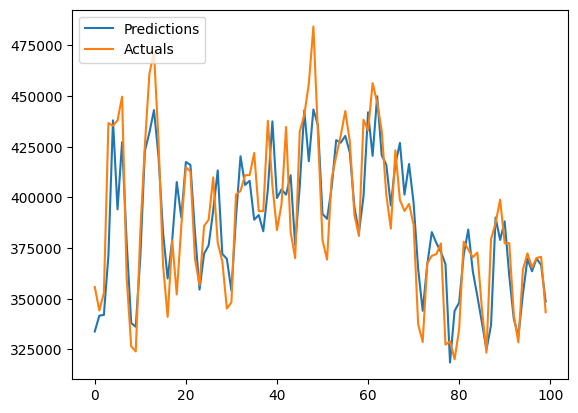

MAPE: 3.44%
RMSE: 18049.02
MAE : 13220.29


Predictions    Actuals
0    333840.15625  355814.96
1    341662.87500  344216.79
2    342029.87500  352812.68
3    371504.75000  436716.40
4    438051.81250  435360.14
..            ...        ...
719  382037.75000  353967.95
720  391870.34375  385900.00
721  396473.87500  411636.83
722  391282.81250  379656.38
723  354437.37500  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model13 = load_model('model13.keras')

# print training metrics
predictions_plot(model13, X_train13, y_train13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


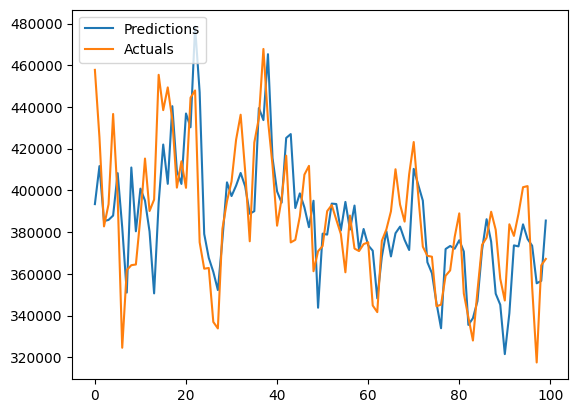

MAPE: 3.74%
RMSE: 18729.72
MAE : 14278.76


Predictions    Actuals
0    393418.46875  457780.70
1    411650.18750  425439.99
2    385291.12500  382741.80
3    385846.43750  393359.12
4    387927.21875  436628.85
..            ...        ...
353  394601.06250  405457.46
354  405345.12500  421027.63
355  402021.75000  407376.71
356  384900.87500  402263.51
357  378237.90625  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model13, X_val13, y_val13, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


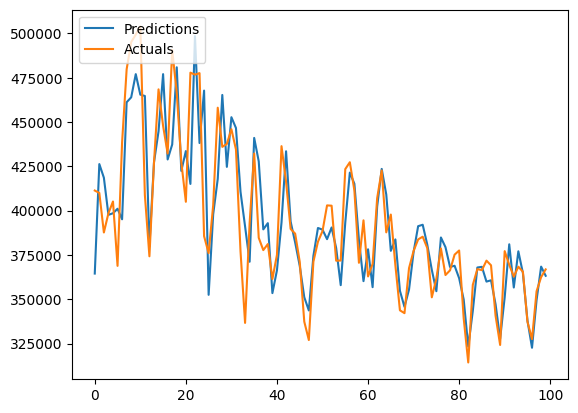

MAPE: 3.93%
RMSE: 19670.14
MAE : 14962.30


Predictions    Actuals
0    364499.53125  411339.27
1    426274.65625  409963.40
2    418580.21875  387672.63
3    397629.03125  398542.65
4    398528.96875  405159.36
..            ...        ...
353  387233.40625  360393.59
354  387543.21875  369325.03
355  385013.21875  371819.56
356  377353.40625  399427.25
357  374829.84375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model13, X_test13, y_test13, 0, 100)

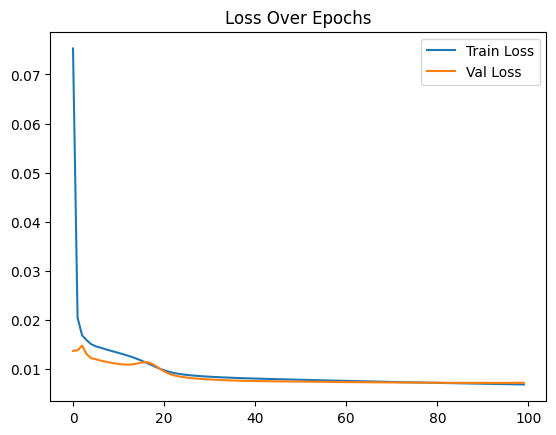

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history13.history['loss'], label='Train Loss')
plt.plot(history13.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Model 14 - Precipitation and Sunlight ###

In [ ]:
# Add precipitation back to feature set to test both extra features
tempPreSunDemandDF = test_df[['sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'precipitation', 'sunlight', 'temp_range']].copy()


In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(tempPreSunDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data14 = preprocessor.get_model_inputs(target_col = 'sum_30_min_demand')

# Prepare splits for model run
X_train14, y_train14 = data14['train']
X_val14, y_val14 = data14['val']
X_test14, y_test14 = data14['test']

# Initialise variables for input layer
i = X_train14.shape[1]
j = X_train14.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model14 = create_lstm_model()

# create model checkpoint
cp14 = ModelCheckpoint('model14.keras', save_best_only=True)

# compile model
model14.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history14 = model14.fit(X_train14, y_train14, validation_data=(X_val14, y_val14), epochs=100, callbacks=[cp14, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1565 - root_mean_squared_error: 0.3817 - val_loss: 0.0183 - val_root_mean_squared_error: 0.1353
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0216 - root_mean_squared_error: 0.1469 - val_loss: 0.0122 - val_root_mean_squared_error: 0.1105
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0164 - root_mean_squared_error: 0.1279 - val_loss: 0.0134 - val_root_mean_squared_error: 0.1159
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0163 - root_mean_squared_error: 0.1276 - val_loss: 0.0140 - val_root_mean_squared_error: 0.1182
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - root_mean_squared_error: 0.1256 - val_loss: 0.0129 - val_root_mean_squared_error: 0.1137
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0150 - root_mean_squared_error: 0.1226 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


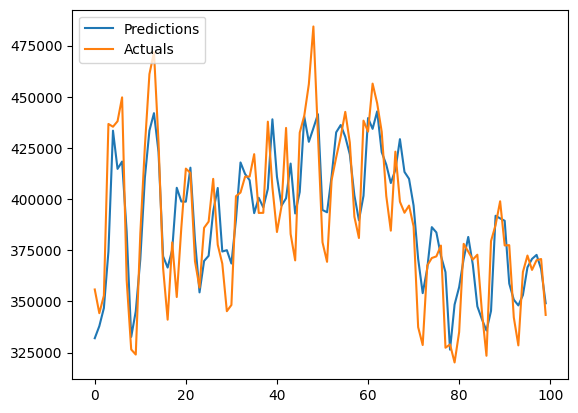

MAPE: 3.80%
RMSE: 19281.34
MAE : 14570.04


Predictions    Actuals
0    331985.09375  355814.96
1    337905.06250  344216.79
2    346721.03125  352812.68
3    374352.28125  436716.40
4    433426.40625  435360.14
..            ...        ...
719  373003.06250  353967.95
720  400764.25000  385900.00
721  395265.18750  411636.83
722  384085.78125  379656.38
723  359997.81250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model14 = load_model('model14.keras')

# print training metrics
predictions_plot(model14, X_train14, y_train14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


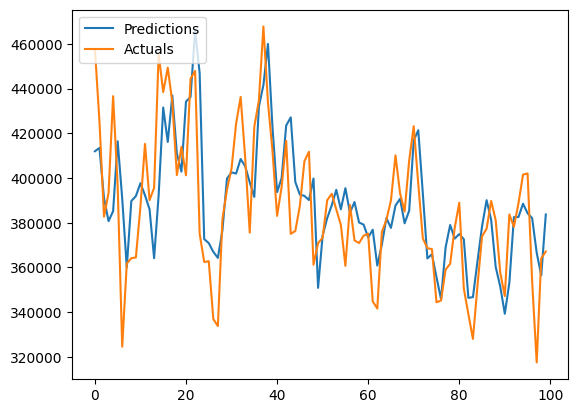

MAPE: 3.74%
RMSE: 18472.86
MAE : 14128.31


Predictions    Actuals
0    411970.75000  457780.70
1    413475.03125  425439.99
2    390959.96875  382741.80
3    380718.65625  393359.12
4    385169.62500  436628.85
..            ...        ...
353  397105.50000  405457.46
354  411267.59375  421027.63
355  411181.00000  407376.71
356  390931.87500  402263.51
357  385684.31250  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model14, X_val14, y_val14, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


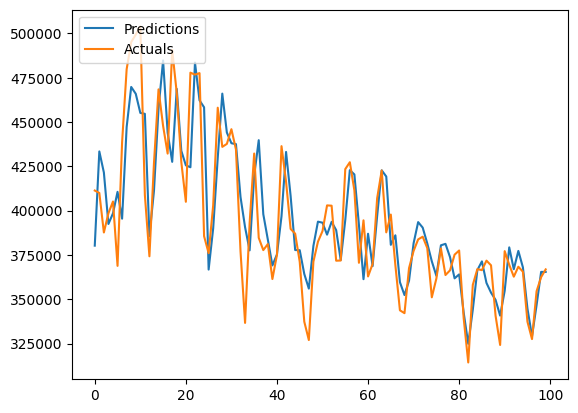

MAPE: 4.17%
RMSE: 20497.58
MAE : 15731.75


Predictions    Actuals
0    380243.00000  411339.27
1    433399.78125  409963.40
2    421515.87500  387672.63
3    392476.75000  398542.65
4    398483.43750  405159.36
..            ...        ...
353  383494.65625  360393.59
354  393653.56250  369325.03
355  392978.65625  371819.56
356  383501.37500  399427.25
357  384628.15625  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model14, X_test14, y_test14, 0, 100)

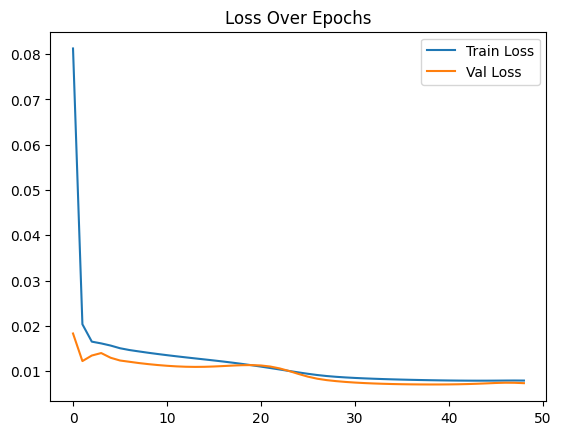

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history14.history['loss'], label='Train Loss')
plt.plot(history14.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 5. Seasonality ##

### Seasons ###

In [ ]:
# Remove precipitation and sunlight due to not adding any valuable information
# to the model.  Add season measures to the dataset.
seasonsDemandDF = test_df[['is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data15 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train15, y_train15 = data15['train']
X_val15, y_val15 = data15['val']
X_test15, y_test15 = data15['test']

# Initialise variables for input layer
i = X_train15.shape[1]
j = X_train15.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model15 = create_lstm_model()

# create model checkpoint
cp15 = ModelCheckpoint('model15.keras', save_best_only=True)

# compile model
model15.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history15 = model15.fit(X_train15, y_train15, validation_data=(X_val15, y_val15), epochs=100, callbacks=[cp15, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0774 - root_mean_squared_error: 0.2702 - val_loss: 0.0187 - val_root_mean_squared_error: 0.1366
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0200 - root_mean_squared_error: 0.1412 - val_loss: 0.0136 - val_root_mean_squared_error: 0.1167
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0170 - root_mean_squared_error: 0.1305 - val_loss: 0.0123 - val_root_mean_squared_error: 0.1110
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0161 - root_mean_squared_error: 0.1268 - val_loss: 0.0121 - val_root_mean_squared_error: 0.1101
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0152 - root_mean_squared_error: 0.1234 - val_loss: 0.0118 - val_root_mean_squared_error: 0.1087
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


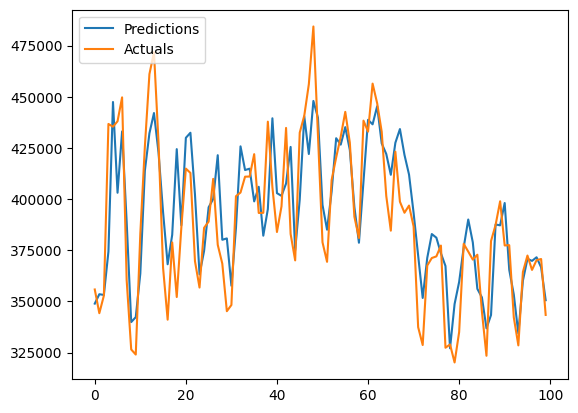

MAPE: 3.38%
RMSE: 17898.13
MAE : 12975.55


Predictions    Actuals
0    348894.34375  355814.96
1    353490.96875  344216.79
2    353150.71875  352812.68
3    374346.59375  436716.40
4    447446.46875  435360.14
..            ...        ...
719  377600.71875  353967.95
720  399843.56250  385900.00
721  399848.28125  411636.83
722  393042.03125  379656.38
723  344288.37500  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model15 = load_model('model15.keras')

# print training metrics
predictions_plot(model15, X_train15, y_train15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


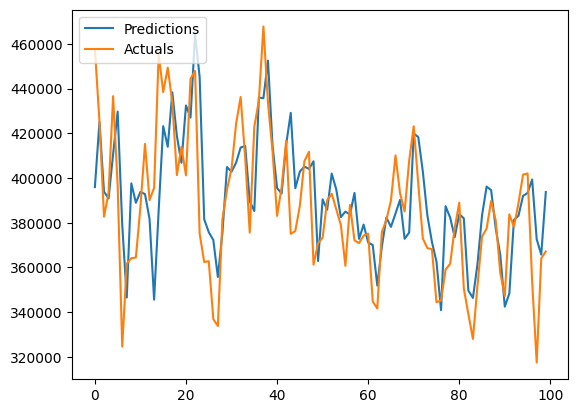

MAPE: 3.54%
RMSE: 18109.50
MAE : 13440.63


Predictions    Actuals
0    395948.71875  457780.70
1    425016.56250  425439.99
2    393945.34375  382741.80
3    390842.37500  393359.12
4    410690.50000  436628.85
..            ...        ...
353  388820.93750  405457.46
354  409281.06250  421027.63
355  403064.87500  407376.71
356  371048.50000  402263.51
357  363668.71875  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model15, X_val15, y_val15, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


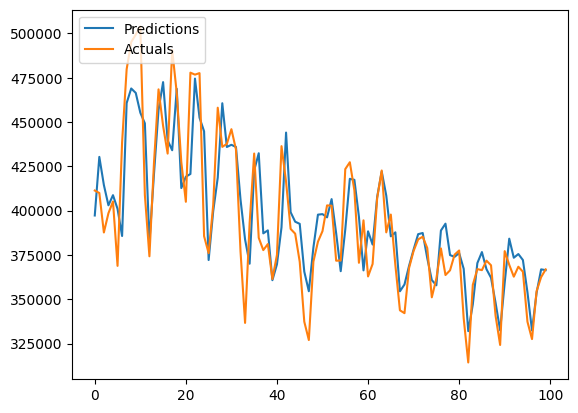

MAPE: 3.70%
RMSE: 18700.75
MAE : 13984.39


Predictions    Actuals
0    397255.25000  411339.27
1    430318.15625  409963.40
2    414462.84375  387672.63
3    403017.68750  398542.65
4    408723.65625  405159.36
..            ...        ...
353  382291.68750  360393.59
354  384659.96875  369325.03
355  389146.43750  371819.56
356  377953.43750  399427.25
357  378028.50000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model15, X_test15, y_test15, 0, 100)

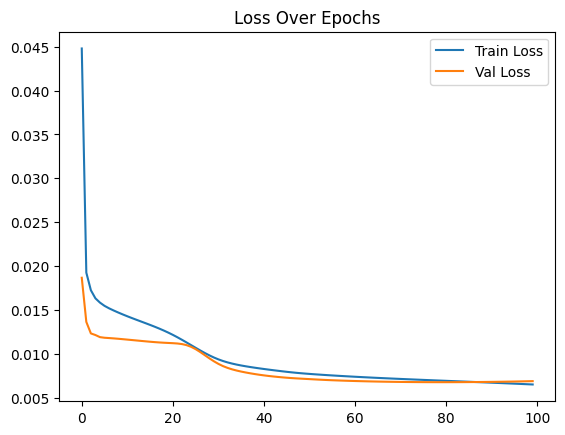

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history15.history['loss'], label='Train Loss')
plt.plot(history15.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Weekday/Weekend ###

In [ ]:
# Remove seasons and investigate the introduction of weekday/weekend dichotomy
weekendDemandDF = test_df[['is_weekday', 'is_weekend', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data16 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train16, y_train16 = data16['train']
X_val16, y_val16 = data16['val']
X_test16, y_test16 = data16['test']

# Initialise variables for input layer
i = X_train16.shape[1]
j = X_train16.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model16 = create_lstm_model()

# create model checkpoint
cp16 = ModelCheckpoint('model16.keras', save_best_only=True)

# compile model
model16.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history16 = model16.fit(X_train16, y_train16, validation_data=(X_val16, y_val16), epochs=100, callbacks=[cp16, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.1390 - root_mean_squared_error: 0.3578 - val_loss: 0.0150 - val_root_mean_squared_error: 0.1227
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0173 - root_mean_squared_error: 0.1313 - val_loss: 0.0101 - val_root_mean_squared_error: 0.1007
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0130 - root_mean_squared_error: 0.1140 - val_loss: 0.0112 - val_root_mean_squared_error: 0.1056
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0123 - root_mean_squared_error: 0.1107 - val_loss: 0.0099 - val_root_mean_squared_error: 0.0997
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0108 - root_mean_squared_error: 0.1039 - val_loss: 0.0090 - val_root_mean_squared_error: 0.0949
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0101 - root_mean_squared_error: 0.1005 - val_loss: 0.0088 - val_root_mean_squared_error: 0.0937
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step -

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


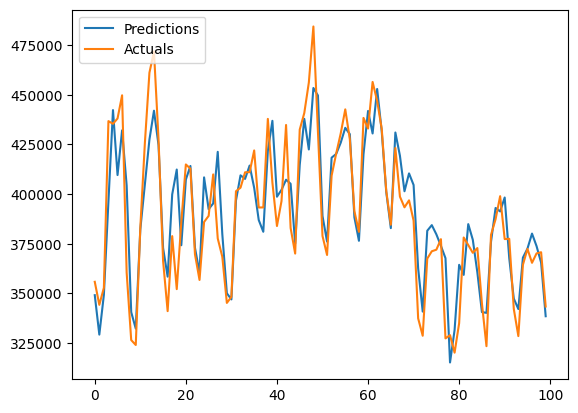

MAPE: 2.95%
RMSE: 16000.32
MAE : 11313.88


Predictions    Actuals
0    349086.31250  355814.96
1    329236.40625  344216.79
2    349251.87500  352812.68
3    396299.21875  436716.40
4    442268.28125  435360.14
..            ...        ...
719  352918.25000  353967.95
720  382363.03125  385900.00
721  386762.68750  411636.83
722  372619.00000  379656.38
723  350276.59375  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model16 = load_model('model16.keras')

# print training metrics
predictions_plot(model16, X_train16, y_train16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


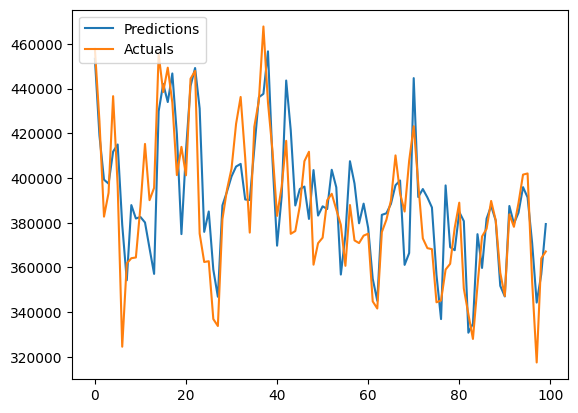

MAPE: 3.14%
RMSE: 16121.05
MAE : 11918.71


Predictions    Actuals
0    453332.75000  457780.70
1    419031.28125  425439.99
2    399274.43750  382741.80
3    397494.21875  393359.12
4    411819.84375  436628.85
..            ...        ...
353  366455.46875  405457.46
354  383240.18750  421027.63
355  374920.00000  407376.71
356  373444.65625  402263.51
357  416886.31250  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model16, X_val16, y_val16, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


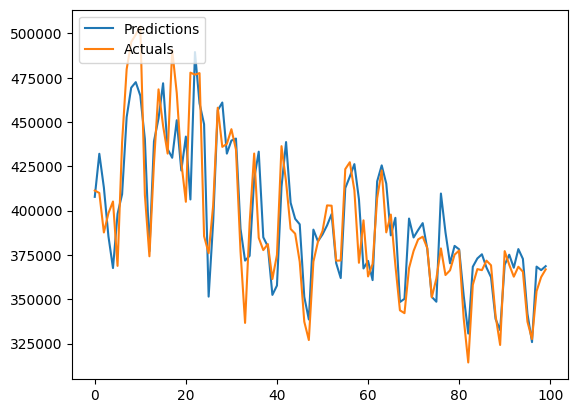

MAPE: 3.42%
RMSE: 17526.89
MAE : 12999.85


Predictions    Actuals
0    407770.87500  411339.27
1    432078.31250  409963.40
2    413031.43750  387672.63
3    385529.62500  398542.65
4    367622.21875  405159.36
..            ...        ...
353  349956.34375  360393.59
354  335364.43750  369325.03
355  365043.65625  371819.56
356  406984.31250  399427.25
357  401008.46875  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model16, X_test16, y_test16, 0, 100)

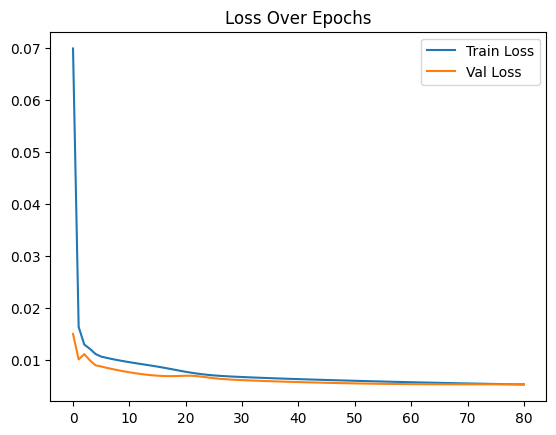

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history16.history['loss'], label='Train Loss')
plt.plot(history16.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Day Of Week ###

In [ ]:
# Investigate Day Of Week features
dayDemandDF = test_df[['is_sunday','is_monday', 'is_tuesday', 'is_wednesday', 'is_thursday', 'is_friday','is_saturday', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(dayDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data17 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train17, y_train17 = data17['train']
X_val17, y_val17 = data17['val']
X_test17, y_test17 = data17['test']

# Initialise variables for input layer
i = X_train17.shape[1]
j = X_train17.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model17 = create_lstm_model()

# create model checkpoint
cp17 = ModelCheckpoint('model17.keras', save_best_only=True)

# compile model
model17.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history17 = model17.fit(X_train17, y_train17, validation_data=(X_val17, y_val17), epochs=100, callbacks=[cp17, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0553 - root_mean_squared_error: 0.2312 - val_loss: 0.0192 - val_root_mean_squared_error: 0.1386
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0156 - root_mean_squared_error: 0.1250 - val_loss: 0.0087 - val_root_mean_squared_error: 0.0932
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0096 - root_mean_squared_error: 0.0978 - val_loss: 0.0085 - val_root_mean_squared_error: 0.0920
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0090 - root_mean_squared_error: 0.0946 - val_loss: 0.0077 - val_root_mean_squared_error: 0.0878
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0085 - root_mean_squared_error: 0.0921 - val_loss: 0.0075 - val_root_mean_squared_error: 0.0865
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0082 - root_mean_squared_error: 0.0906 - val_loss: 0.0073 - val_root_mean_squared_error: 0.0856
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


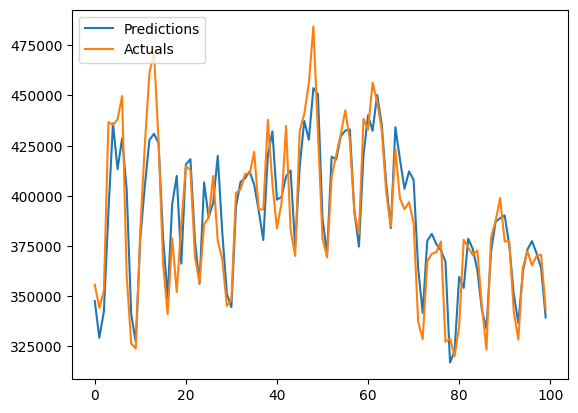

MAPE: 2.66%
RMSE: 14856.81
MAE : 10259.21


Predictions    Actuals
0    347601.50000  355814.96
1    329372.37500  344216.79
2    342406.65625  352812.68
3    392018.46875  436716.40
4    436111.21875  435360.14
..            ...        ...
719  344286.28125  353967.95
720  381713.53125  385900.00
721  384952.46875  411636.83
722  376586.46875  379656.38
723  345535.56250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model17 = load_model('model17.keras')

# print training metrics
predictions_plot(model17, X_train17, y_train17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


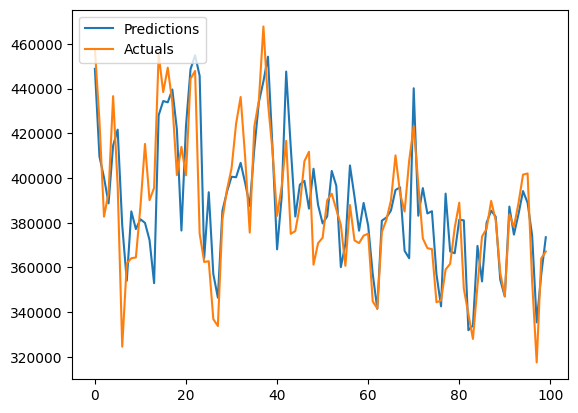

MAPE: 2.87%
RMSE: 15319.57
MAE : 10927.41


Predictions    Actuals
0    448870.06250  457780.70
1    409664.56250  425439.99
2    400217.90625  382741.80
3    388662.81250  393359.12
4    414550.31250  436628.85
..            ...        ...
353  361906.53125  405457.46
354  381448.50000  421027.63
355  376827.40625  407376.71
356  366088.21875  402263.51
357  414924.21875  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model17, X_val17, y_val17, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


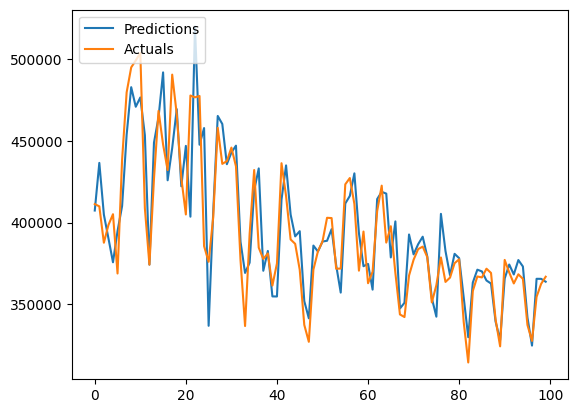

MAPE: 3.15%
RMSE: 16661.19
MAE : 12026.87


Predictions    Actuals
0    407403.40625  411339.27
1    436579.93750  409963.40
2    404898.12500  387672.63
3    390424.09375  398542.65
4    375715.06250  405159.36
..            ...        ...
353  349014.96875  360393.59
354  336823.40625  369325.03
355  354791.06250  371819.56
356  405874.59375  399427.25
357  389257.59375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model17, X_test17, y_test17, 0, 100)

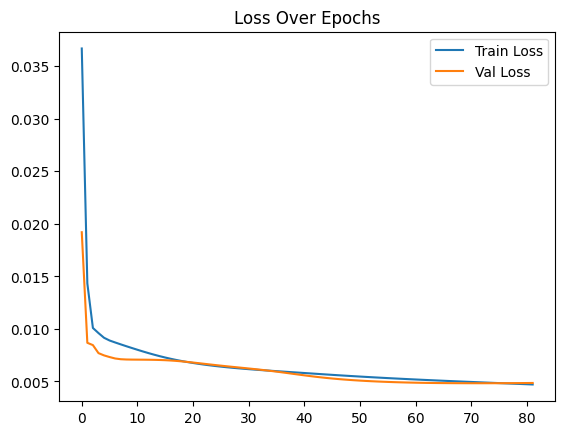

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history17.history['loss'], label='Train Loss')
plt.plot(history17.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Month ###

In [ ]:
# Investigate month features
monthDemandDF = test_df[['is_jan', 'is_feb', 'is_mar','is_apr', 'is_may', 'is_jun', 'is_jul', 'is_aug', 'is_sep', 'is_oct','is_nov', 'is_dec', 'sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h', 'temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(monthDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data18 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train18, y_train18 = data18['train']
X_val18, y_val18 = data18['val']
X_test18, y_test18 = data18['test']

# Initialise variables for input layer
i = X_train18.shape[1]
j = X_train18.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model18 = create_lstm_model()

# create model checkpoint
cp18 = ModelCheckpoint('model18.keras', save_best_only=True)

# compile model
model18.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history18 = model18.fit(X_train18, y_train18, validation_data=(X_val18, y_val18), epochs=100, callbacks=[cp18, es2])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0600 - root_mean_squared_error: 0.2411 - val_loss: 0.0188 - val_root_mean_squared_error: 0.1372
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0206 - root_mean_squared_error: 0.1436 - val_loss: 0.0120 - val_root_mean_squared_error: 0.1097
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0157 - root_mean_squared_error: 0.1253 - val_loss: 0.0119 - val_root_mean_squared_error: 0.1090
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0152 - root_mean_squared_error: 0.1233 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1072
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0147 - root_mean_squared_error: 0.1210 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1065
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0143 - root_mean_squared_error: 0.1194 - val_loss: 0.0113 - val_root_mean_squared_error: 0.1061
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


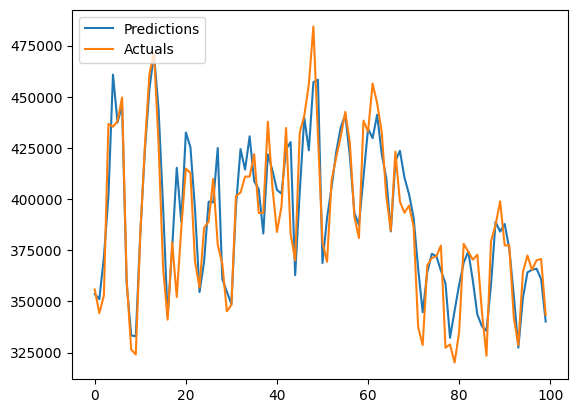

MAPE: 2.87%
RMSE: 15211.63
MAE : 11074.17


Predictions    Actuals
0    353594.34375  355814.96
1    351090.37500  344216.79
2    371473.31250  352812.68
3    401556.46875  436716.40
4    460830.87500  435360.14
..            ...        ...
719  371114.46875  353967.95
720  396505.81250  385900.00
721  403776.84375  411636.83
722  401174.71875  379656.38
723  351913.65625  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model18 = load_model('model18.keras')

# print training metrics
predictions_plot(model18, X_train18, y_train18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


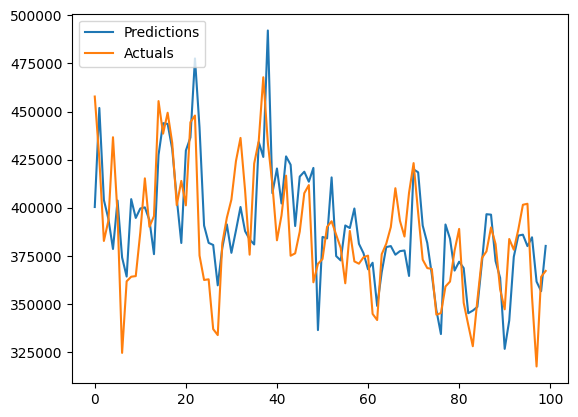

MAPE: 3.78%
RMSE: 19199.27
MAE : 14429.47


Predictions    Actuals
0    400364.21875  457780.70
1    451834.81250  425439.99
2    404033.84375  382741.80
3    394137.87500  393359.12
4    378555.40625  436628.85
..            ...        ...
353  381571.15625  405457.46
354  411013.31250  421027.63
355  414311.71875  407376.71
356  381838.62500  402263.51
357  362441.34375  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model18, X_val18, y_val18, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


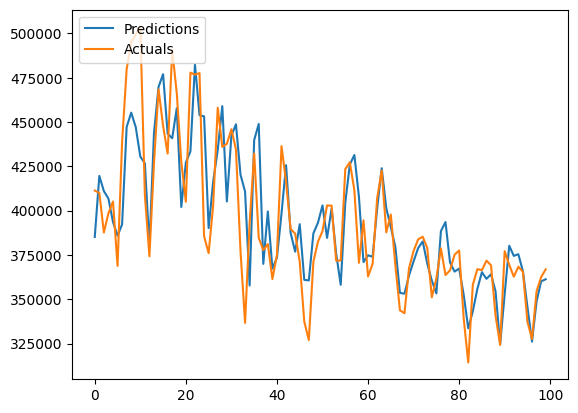

MAPE: 4.07%
RMSE: 20130.17
MAE : 15355.07


Predictions    Actuals
0    385163.75000  411339.27
1    419611.90625  409963.40
2    411023.56250  387672.63
3    406811.43750  398542.65
4    393599.90625  405159.36
..            ...        ...
353  376206.90625  360393.59
354  388147.50000  369325.03
355  388199.59375  371819.56
356  387796.68750  399427.25
357  385594.87500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model18, X_test18, y_test18, 0, 100)

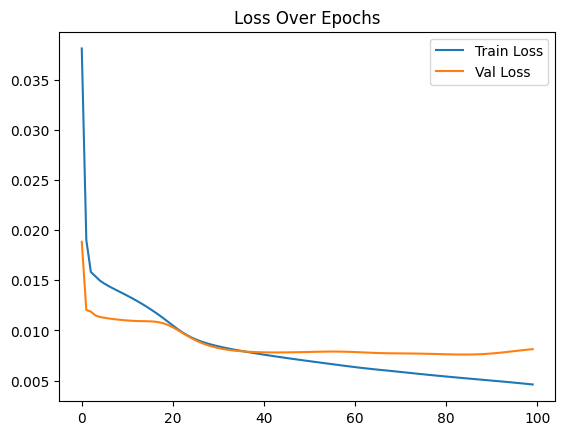

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history18.history['loss'], label='Train Loss')
plt.plot(history18.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

### Seasons & Weekday/Weekend ###

In [ ]:
# Add seasons and weekday/weekend to feature set from Model 10 (optimal so far)
# N.B. Seasons and weekday/weekend were chosen due to best results so far without
# overfitting.  Month features and day of week showed signs of overfitting
seasonsWdWeDemandDF = test_df[['is_weekend','is_weekday','is_winter', 'is_spring', 'is_summer', 'is_autumn','sum_30_min_demand', 'avg_temp', 'min_temp', 'max_temp', 'hd_next_24h', 'cd_next_24h','temp_range']].copy()

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTVT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data19 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train19, y_train19 = data19['train']
X_val19, y_val19 = data19['val']
X_test19, y_test19 = data19['test']

# Initialise variables for input layer
i = X_train19.shape[1]
j = X_train19.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model19 = create_lstm_model()

# create model checkpoint
cp19 = ModelCheckpoint('model19.keras', save_best_only=True)

# compile model
model19.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history19 = model19.fit(X_train19, y_train19, validation_data=(X_val19, y_val19), epochs=100, callbacks=[cp19, es3])

Epoch 1/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1401 - root_mean_squared_error: 0.3608 - val_loss: 0.0141 - val_root_mean_squared_error: 0.1189
Epoch 2/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0194 - root_mean_squared_error: 0.1392 - val_loss: 0.0124 - val_root_mean_squared_error: 0.1112
Epoch 3/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0155 - root_mean_squared_error: 0.1245 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1073
Epoch 4/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0131 - root_mean_squared_error: 0.1145 - val_loss: 0.0091 - val_root_mean_squared_error: 0.0954
Epoch 5/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057 - val_loss: 0.0081 - val_root_mean_squared_error: 0.0901
Epoch 6/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0102 - root_mean_squared_error: 0.1010 - val_loss: 0.0079 - val_root_mean_squared_error: 0.0890
Epoch 7/100
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


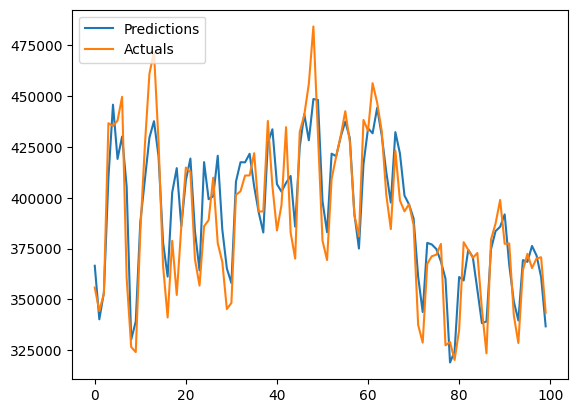

MAPE: 2.92%
RMSE: 16156.34
MAE : 11246.02


Predictions    Actuals
0    366521.09375  355814.96
1    340151.50000  344216.79
2    353213.81250  352812.68
3    409887.75000  436716.40
4    445855.12500  435360.14
..            ...        ...
719  358178.59375  353967.95
720  382897.96875  385900.00
721  386536.87500  411636.83
722  380212.31250  379656.38
723  357534.06250  342930.54

[724 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model19 = load_model('model19.keras')

# print training metrics
predictions_plot(model19, X_train19, y_train19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


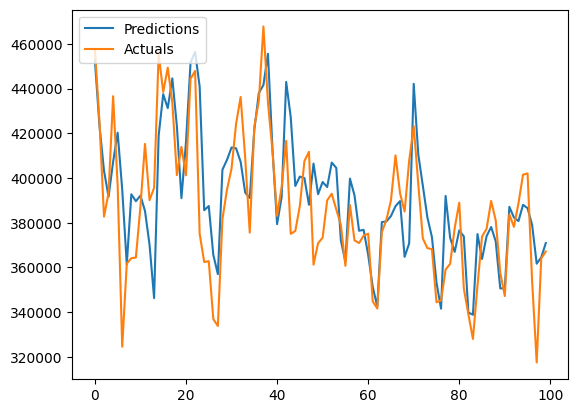

MAPE: 3.14%
RMSE: 16608.10
MAE : 11929.62


Predictions    Actuals
0    452679.56250  457780.70
1    423604.15625  425439.99
2    403277.53125  382741.80
3    391657.84375  393359.12
4    407239.53125  436628.85
..            ...        ...
353  372761.12500  405457.46
354  380558.46875  421027.63
355  372284.34375  407376.71
356  362206.71875  402263.51
357  408573.28125  405023.08

[358 rows x 2 columns]

In [ ]:
# print validation metrics
predictions_plot(model19, X_val19, y_val19, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


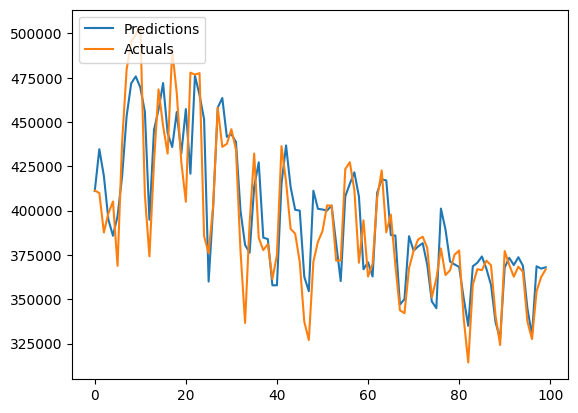

MAPE: 3.31%
RMSE: 17487.59
MAE : 12544.04


Predictions    Actuals
0    411096.40625  411339.27
1    434654.71875  409963.40
2    419536.03125  387672.63
3    394850.03125  398542.65
4    385824.21875  405159.36
..            ...        ...
353  357357.00000  360393.59
354  342993.34375  369325.03
355  356296.59375  371819.56
356  403657.90625  399427.25
357  403715.40625  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model19, X_test19, y_test19, 0, 100)

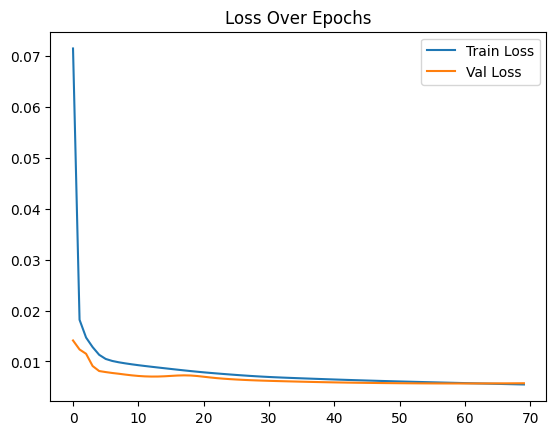

In [ ]:
# Plot validation loss vs train loss to confirm no overfitting
plt.plot(history19.history['loss'], label='Train Loss')
plt.plot(history19.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Over Epochs")
plt.show()

## 6. Train/test Only - Compare Most Successful Models ##

### Seasons & Weekday/Weekend - Train/Test ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data20 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train20, y_train20 = data20['train']
X_test20, y_test20 = data20['test']

# Initialise variables for input layer
i = X_train20.shape[1]
j = X_train20.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model20 = create_lstm_model()

# create model checkpoint
cp20 = ModelCheckpoint('model20.keras', monitor='loss', save_best_only=True)

# compile model
model20.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history20 = model20.fit(X_train20, y_train20, epochs=100, callbacks=[cp20])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1158 - root_mean_squared_error: 0.3248
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0135 - root_mean_squared_error: 0.1163
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0112 - root_mean_squared_error: 0.1060
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - root_mean_squared_error: 0.1008
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - root_mean_squared_error: 0.0973
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0088 - root_mean_squared_error: 0.0935
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0085 - root_mean_squared_error: 0.0923
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0083 - root_mean_squared_error: 0.0913
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0082 - root_mean_squared_error: 0.0903

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


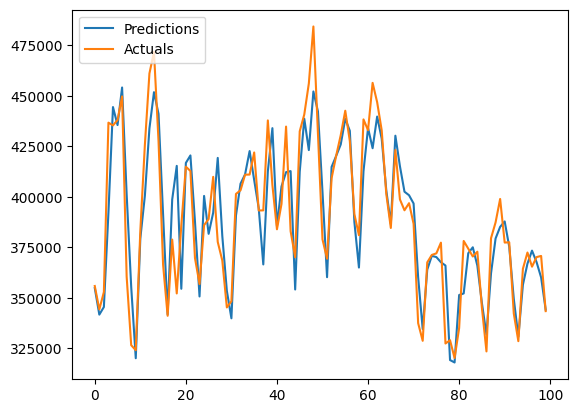

MAPE: 2.54%
RMSE: 13708.68
MAE : 9842.40


Predictions    Actuals
0     354798.09375  355814.96
1     341635.21875  344216.79
2     345403.15625  352812.68
3     392135.65625  436716.40
4     444440.81250  435360.14
...            ...        ...
1084  384169.71875  405457.46
1085  427791.37500  421027.63
1086  403933.46875  407376.71
1087  392693.81250  402263.51
1088  408054.56250  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model20 = load_model('model20.keras')

# print training metrics
predictions_plot(model20, X_train20, y_train20, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


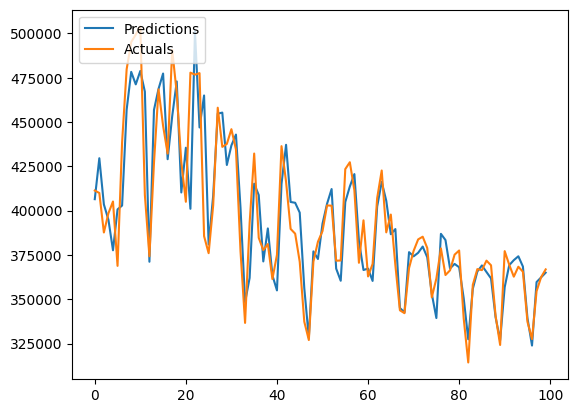

MAPE: 2.88%
RMSE: 15822.23
MAE : 11099.92


Predictions    Actuals
0    406464.62500  411339.27
1    429564.68750  409963.40
2    403502.93750  387672.63
3    394852.93750  398542.65
4    377638.93750  405159.36
..            ...        ...
353  360612.62500  360393.59
354  361172.12500  369325.03
355  387936.90625  371819.56
356  407141.09375  399427.25
357  391891.75000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model20, X_test20, y_test20, 0, 100)

### Seasons Only - Train/Test ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data21 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train21, y_train21 = data21['train']
X_test21, y_test21 = data21['test']

# Initialise variables for input layer
i = X_train21.shape[1]
j = X_train21.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model21 = create_lstm_model()

# create model checkpoint
cp21 = ModelCheckpoint('model21.keras', monitor='loss', save_best_only=True)

# compile model
model21.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history21 = model21.fit(X_train21, y_train21, epochs=100, callbacks=[cp21])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0670 - root_mean_squared_error: 0.2499
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0165 - root_mean_squared_error: 0.1286
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0147 - root_mean_squared_error: 0.1211
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0136 - root_mean_squared_error: 0.1167
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0130 - root_mean_squared_error: 0.1141
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0127 - root_mean_squared_error: 0.1126
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0124 - root_mean_squared_error: 0.1113
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0119 - root_mean_squared_error: 0.1089
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1077

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


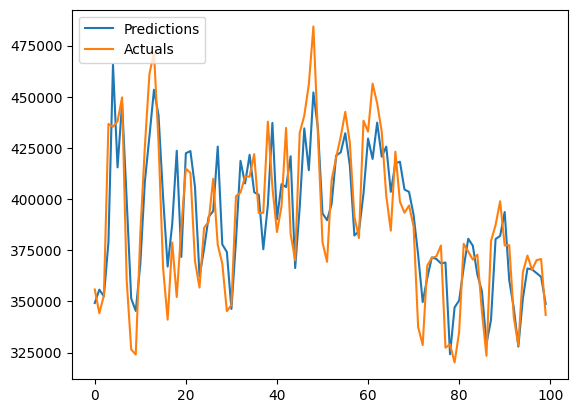

MAPE: 3.16%
RMSE: 16695.91
MAE : 12196.23


Predictions    Actuals
0     349193.28125  355814.96
1     355733.28125  344216.79
2     352489.68750  352812.68
3     378840.25000  436716.40
4     465797.34375  435360.14
...            ...        ...
1084  396190.25000  405457.46
1085  425267.59375  421027.63
1086  414284.59375  407376.71
1087  386662.62500  402263.51
1088  376600.75000  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model21 = load_model('model21.keras')

# print training metrics
predictions_plot(model21, X_train21, y_train21, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


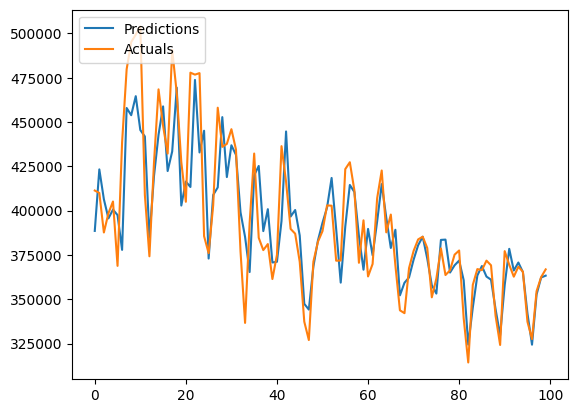

MAPE: 3.58%
RMSE: 18569.07
MAE : 13615.21


Predictions    Actuals
0    388563.43750  411339.27
1    423267.12500  409963.40
2    406409.25000  387672.63
3    395618.34375  398542.65
4    400581.59375  405159.36
..            ...        ...
353  385660.40625  360393.59
354  384007.34375  369325.03
355  389818.06250  371819.56
356  372605.78125  399427.25
357  376602.50000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model21, X_test21, y_test21, 0, 100)

### Weekend/Weekday Only - Train/Test ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(weekendDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data22 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train22, y_train22 = data22['train']
X_test22, y_test22 = data22['test']

# Initialise variables for input layer
i = X_train22.shape[1]
j = X_train22.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model22 = create_lstm_model()

# create model checkpoint
cp22 = ModelCheckpoint('model22.keras', monitor='loss', save_best_only=True)

# compile model
model22.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.001, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history22 = model22.fit(X_train22, y_train22, epochs=100, callbacks=[cp22])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.1086 - root_mean_squared_error: 0.3142
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0126 - root_mean_squared_error: 0.1121
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0108 - root_mean_squared_error: 0.1038
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0102 - root_mean_squared_error: 0.1009
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0096 - root_mean_squared_error: 0.0980
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0966
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0091 - root_mean_squared_error: 0.0953
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0088 - root_mean_squared_error: 0.0940
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0086 - root_mean_squared_error: 0.0927

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


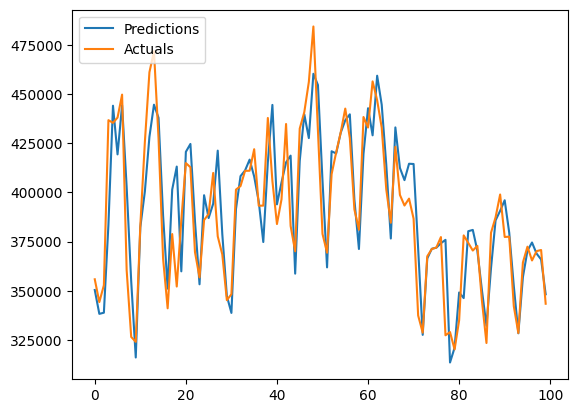

MAPE: 2.70%
RMSE: 14423.87
MAE : 10385.48


Predictions    Actuals
0     350368.25000  355814.96
1     338233.46875  344216.79
2     338819.12500  352812.68
3     383646.56250  436716.40
4     444063.21875  435360.14
...            ...        ...
1084  367079.87500  405457.46
1085  405129.25000  421027.63
1086  386454.65625  407376.71
1087  378794.65625  402263.51
1088  405860.84375  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model22 = load_model('model22.keras')

# print training metrics
predictions_plot(model22, X_train22, y_train22, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


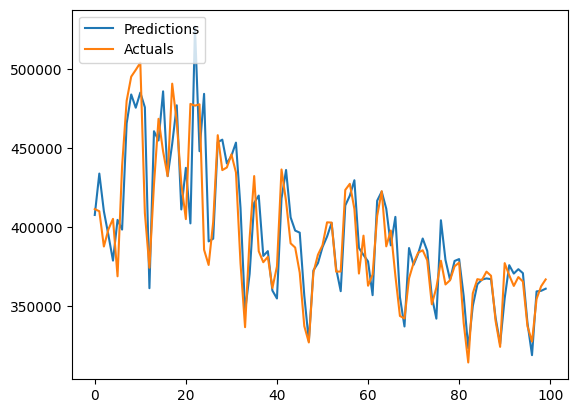

MAPE: 3.02%
RMSE: 16504.69
MAE : 11578.33


Predictions    Actuals
0    407616.12500  411339.27
1    433791.00000  409963.40
2    409966.59375  387672.63
3    394838.00000  398542.65
4    378772.09375  405159.36
..            ...        ...
353  351656.28125  360393.59
354  355206.81250  369325.03
355  373650.37500  371819.56
356  403983.84375  399427.25
357  386811.62500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model22, X_test22, y_test22, 0, 100)

## 7. Optuna Trials ##

In [ ]:
# Create Optuna study
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

# Run study
study.optimize(objective, n_trials=100)

"study = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy.optimize(objective, n_trials=100)"

In [ ]:
# Print results of best Optuna run
print("Best trial:")
trial = study.best_trial

print(f"  MAE: {trial.value:.2f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

'print("Best trial:")\ntrial = study.best_trial\n\nprint(f"  MAE: {trial.value:.2f}")\nprint("  Params:")\nfor key, value in trial.params.items():\n    print(f"    {key}: {value}")'

In [ ]:
# Create Optuna study with early stopping and model checkpoints
study2 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler()
)

# Run study
study2.optimize(objective2, n_trials=100)

"study2 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy2.optimize(objective2, n_trials=100)"

In [ ]:
# Print results of best Optuna run
print("Best trial:")
trial2 = study2.best_trial

print(f"  MAE: {trial2.value:.2f}")
print("  Params:")
for key, value in trial2.params.items():
    print(f"    {key}: {value}")

'print("Best trial:")\ntrial2 = study2.best_trial\n\nprint(f"  MAE: {trial2.value:.2f}")\nprint("  Params:")\nfor key, value in trial2.params.items():\n    print(f"    {key}: {value}")'

### Model 20 Re-Run (Post Optuna) ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data23 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train23, y_train23 = data23['train']
X_test23, y_test23 = data23['test']

# Initialise variables for input layer
i = X_train23.shape[1]
j = X_train23.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model23 = create_lstm_model(n_units = 32, dropout = 0.013)

# create model checkpoint
cp23 = ModelCheckpoint('model23.keras', monitor='loss', save_best_only=True)

# compile model
model23.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history23 = model23.fit(X_train23, y_train23, epochs=100, batch_size=8, callbacks=[cp23])


Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0610 - root_mean_squared_error: 0.2359
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0140 - root_mean_squared_error: 0.1182
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0118 - root_mean_squared_error: 0.1086
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - root_mean_squared_error: 0.0993
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0961
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0089 - root_mean_squared_error: 0.0943
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0098 - root_mean_squared_error: 0.0986
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0089 - root_mean_squared_error: 0.0940
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0086 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


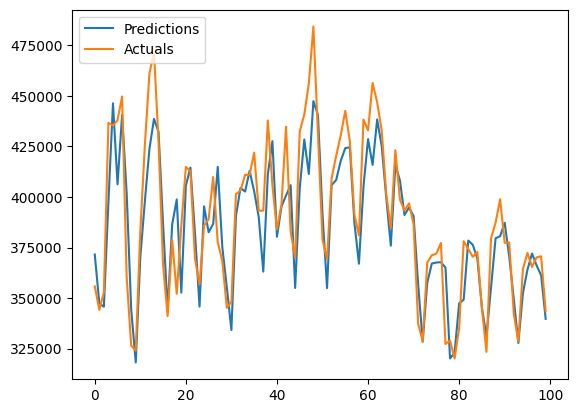

MAPE: 2.71%
RMSE: 14983.12
MAE : 10616.47


Predictions    Actuals
0     371582.87500  355814.96
1     347417.81250  344216.79
2     345732.53125  352812.68
3     397637.06250  436716.40
4     446347.25000  435360.14
...            ...        ...
1084  385363.25000  405457.46
1085  428000.78125  421027.63
1086  406796.71875  407376.71
1087  378214.65625  402263.51
1088  410574.81250  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model23 = load_model('model23.keras')

# print training metrics
predictions_plot(model23, X_train23, y_train23, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


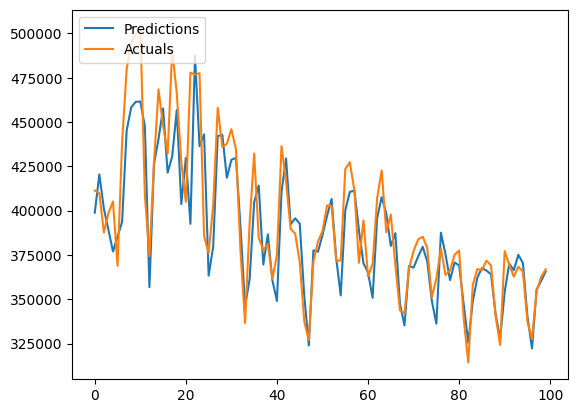

MAPE: 2.88%
RMSE: 15987.32
MAE : 11163.37


Predictions    Actuals
0    398847.93750  411339.27
1    420437.46875  409963.40
2    401102.53125  387672.63
3    389200.46875  398542.65
4    376948.78125  405159.36
..            ...        ...
353  367841.15625  360393.59
354  366874.40625  369325.03
355  380101.34375  371819.56
356  409445.68750  399427.25
357  405955.78125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model23, X_test23, y_test23, 0, 100)

### Model 20 Re-Run (Post Optuna Trial 2) ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data24 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train24, y_train24 = data24['train']
X_test24, y_test24 = data24['test']

# Initialise variables for input layer
i = X_train24.shape[1]
j = X_train24.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model24 = create_lstm_model(n_units=57, dropout=0.013)

# create model checkpoint
cp24 = ModelCheckpoint('model24.keras', monitor='loss', save_best_only=True)

# compile model
model24.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0012, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history24 = model24.fit(X_train24, y_train24, epochs=100, batch_size=32, callbacks=[cp24])


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0715 - root_mean_squared_error: 0.2575
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0148 - root_mean_squared_error: 0.1215
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0113 - root_mean_squared_error: 0.1064
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0109 - root_mean_squared_error: 0.1044
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0096 - root_mean_squared_error: 0.0981
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0095 - root_mean_squared_error: 0.0977
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0964
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0093 - root_mean_squared_error: 0.0962
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0089 - root_mean_squared_error: 0.0945

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


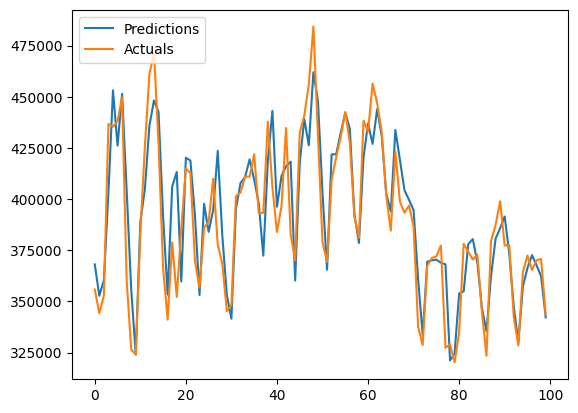

MAPE: 2.54%
RMSE: 13869.55
MAE : 9799.79


Predictions    Actuals
0     368063.40625  355814.96
1     352725.40625  344216.79
2     360415.00000  352812.68
3     403227.65625  436716.40
4     453135.15625  435360.14
...            ...        ...
1084  390627.90625  405457.46
1085  427712.40625  421027.63
1086  409767.71875  407376.71
1087  398726.18750  402263.51
1088  421296.78125  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model24 = load_model('model24.keras')

# print training metrics
predictions_plot(model24, X_train24, y_train24, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


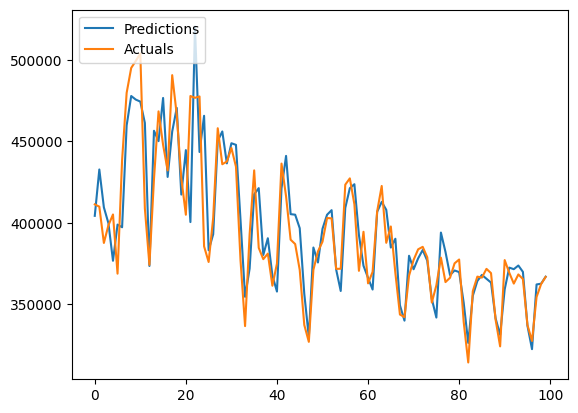

MAPE: 2.95%
RMSE: 16208.83
MAE : 11320.77


Predictions    Actuals
0    404313.93750  411339.27
1    432752.75000  409963.40
2    409508.21875  387672.63
3    399794.12500  398542.65
4    376752.84375  405159.36
..            ...        ...
353  371223.00000  360393.59
354  373104.71875  369325.03
355  396127.00000  371819.56
356  415911.56250  399427.25
357  411806.12500  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model24, X_test24, y_test24, 0, 100)

### Model 20 Re-Run (Post Optuna) - Batch Size Adjust ###

In [ ]:
# Test adjustment of batch size (quicker weight updates, slower computation)

# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data25 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train25, y_train25 = data25['train']
X_test25, y_test25 = data25['test']

# Initialise variables for input layer
i = X_train25.shape[1]
j = X_train25.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model25 = create_lstm_model(n_units=32, dropout=0.013)

# create model checkpoint
cp25 = ModelCheckpoint('model25.keras', monitor='loss', save_best_only=True)

# compile model
model25.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history25 = model25.fit(X_train25, y_train25, epochs=100, batch_size=4, callbacks=[cp25])

Epoch 1/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0506 - root_mean_squared_error: 0.2112
Epoch 2/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057
Epoch 3/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0099 - root_mean_squared_error: 0.0995
Epoch 4/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0095 - root_mean_squared_error: 0.0975
Epoch 5/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0955
Epoch 6/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0086 - root_mean_squared_error: 0.0924
Epoch 7/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0093 - root_mean_squared_error: 0.0961
Epoch 8/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0083 - root_mean_squared_error: 0.0907
Epoch 9/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0090 - root_mean_squared_error: 0.0938
Epoch 10/100
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0078 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


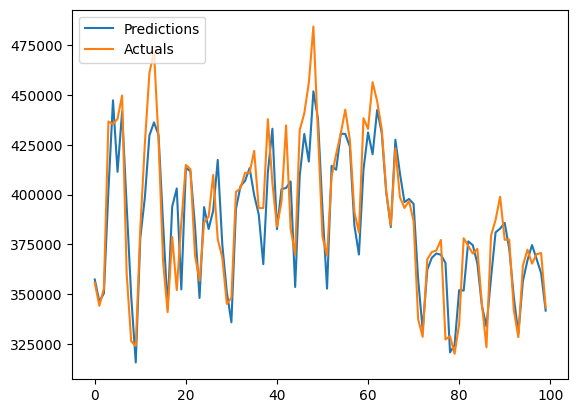

MAPE: 2.57%
RMSE: 14146.28
MAE : 10056.44


Predictions    Actuals
0     357426.56250  355814.96
1     346415.03125  344216.79
2     350410.06250  352812.68
3     402119.00000  436716.40
4     447312.03125  435360.14
...            ...        ...
1084  382792.21875  405457.46
1085  419191.06250  421027.63
1086  398460.59375  407376.71
1087  384041.78125  402263.51
1088  409528.62500  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model25 = load_model('model25.keras')

# print training metrics
predictions_plot(model25, X_train25, y_train25, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


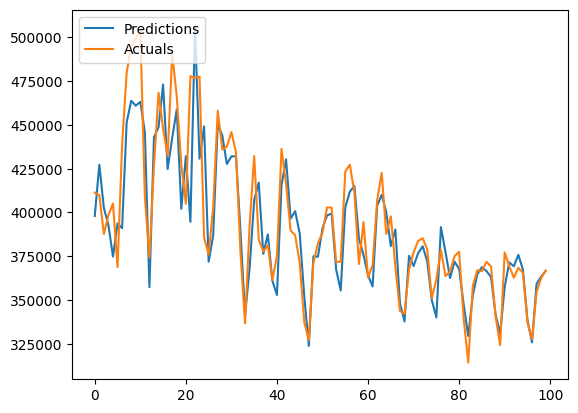

MAPE: 2.84%
RMSE: 15824.97
MAE : 11030.20


Predictions    Actuals
0    398000.25000  411339.27
1    427221.50000  409963.40
2    402581.50000  387672.63
3    392677.96875  398542.65
4    374841.56250  405159.36
..            ...        ...
353  358628.87500  360393.59
354  363218.71875  369325.03
355  385912.25000  371819.56
356  414275.62500  399427.25
357  406605.34375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model25, X_test25, y_test25, 0, 100)

## 8. Architecture Exploration ##

### Stacked LSTM - From Model 23 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data26 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train26, y_train26 = data26['train']
X_test26, y_test26 = data26['test']

# Initialise variables for input layer
i = X_train26.shape[1]
j = X_train26.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model26 = create_stacked_lstm_model()

# create model checkpoint
cp26 = ModelCheckpoint('model26.keras', monitor='loss', save_best_only=True)

# compile model
model26.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history26 = model26.fit(X_train26, y_train26, epochs=100, batch_size=8, callbacks=[cp26])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0812 - root_mean_squared_error: 0.2677
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0143 - root_mean_squared_error: 0.1195
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0142 - root_mean_squared_error: 0.1188
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0132 - root_mean_squared_error: 0.1149
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0121 - root_mean_squared_error: 0.1100
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0120 - root_mean_squared_error: 0.1093
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0116 - root_mean_squared_error: 0.1075
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0123 - root_mean_squared_error: 0.1106
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0114 - root_mean_squared_error: 0.1067
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0112 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


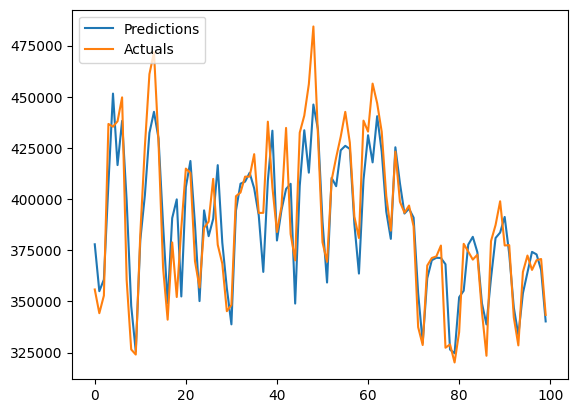

MAPE: 2.54%
RMSE: 13926.88
MAE : 9851.49


Predictions    Actuals
0     377897.71875  355814.96
1     354975.62500  344216.79
2     360654.06250  352812.68
3     407569.75000  436716.40
4     451557.71875  435360.14
...            ...        ...
1084  384703.15625  405457.46
1085  418874.03125  421027.63
1086  412689.37500  407376.71
1087  392465.34375  402263.51
1088  413444.71875  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model26 = load_model('model26.keras')

# print training metrics
predictions_plot(model26, X_train26, y_train26, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


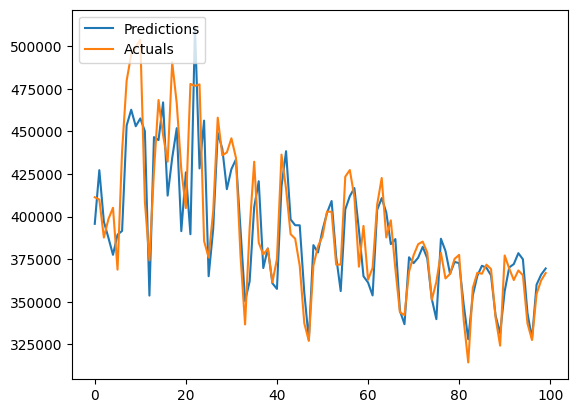

MAPE: 3.08%
RMSE: 16948.45
MAE : 11857.57


Predictions    Actuals
0    395728.37500  411339.27
1    427242.12500  409963.40
2    396982.93750  387672.63
3    387515.84375  398542.65
4    377545.12500  405159.36
..            ...        ...
353  364925.59375  360393.59
354  367402.46875  369325.03
355  393207.56250  371819.56
356  422799.53125  399427.25
357  406821.25000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model26, X_test26, y_test26, 0, 100)

### CNN-LSTM Test - From Model 23 ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data27 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train27, y_train27 = data27['train']
X_test27, y_test27 = data27['test']

# Initialise variables for input layer
i = X_train27.shape[1]
j = X_train27.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model27 = create_cnn_lstm_model()

# create model checkpoint
cp27 = ModelCheckpoint('model27.keras', monitor='loss', save_best_only=True)

# compile model
model27.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history27 = model27.fit(X_train27, y_train27, epochs=100, batch_size=8, callbacks=[cp27])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0976 - root_mean_squared_error: 0.2918
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0126 - root_mean_squared_error: 0.1120
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0121 - root_mean_squared_error: 0.1097
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - root_mean_squared_error: 0.1092
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0119 - root_mean_squared_error: 0.1086
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0112 - root_mean_squared_error: 0.1057
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0109 - root_mean_squared_error: 0.1041
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - root_mean_squared_error: 0.1032
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0108 - root_mean_squared_error: 0.1037
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0100 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


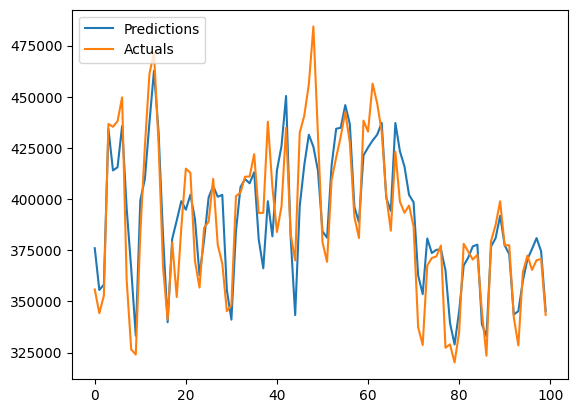

MAPE: 2.82%
RMSE: 14233.68
MAE : 10742.08


Predictions    Actuals
0     375977.81250  355814.96
1     355568.46875  344216.79
2     358197.12500  352812.68
3     434223.65625  436716.40
4     414000.81250  435360.14
...            ...        ...
1084  410955.90625  405457.46
1085  419440.00000  421027.63
1086  399905.59375  407376.71
1087  387844.25000  402263.51
1088  382385.34375  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model27 = load_model('model27.keras')

# print training metrics
predictions_plot(model27, X_train27, y_train27, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


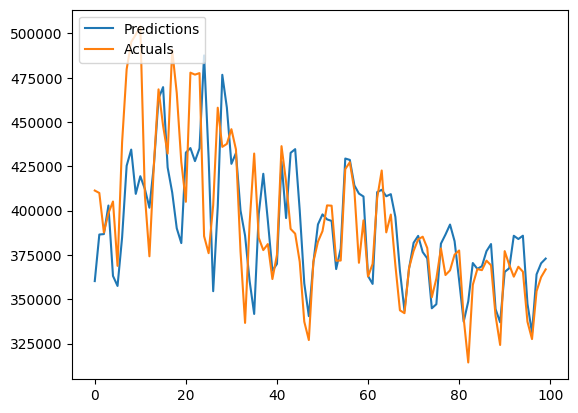

MAPE: 4.86%
RMSE: 25308.77
MAE : 18582.17


Predictions    Actuals
0    360254.71875  411339.27
1    386525.71875  409963.40
2    386775.15625  387672.63
3    402878.53125  398542.65
4    363166.18750  405159.36
..            ...        ...
353  372656.46875  360393.59
354  359266.09375  369325.03
355  387607.34375  371819.56
356  408448.34375  399427.25
357  403877.28125  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model27, X_test27, y_test27, 0, 100)

### CNN-LSTM Optuna Trials ###

In [ ]:
# Create Optuna study for CNN-LSTM model
study3 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

# Run study
study3.optimize(objective3, n_trials=100)

"study3 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy3.optimize(objective3, n_trials=100)"

In [ ]:
# Print results of best Optuna run
print("Best trial:")
trial3 = study3.best_trial

print(f"  MAE: {trial3.value:.2f}")
print("  Params:")
for key, value in trial3.params.items():
    print(f"    {key}: {value}")

'print("Best trial:")\ntrial3 = study3.best_trial\n\nprint(f"  MAE: {trial3.value:.2f}")\nprint("  Params:")\nfor key, value in trial3.params.items():\n    print(f"    {key}: {value}")'

## 9. Final Feature Adjustments ##

### Explore Temp^2 ###

In [ ]:
seasonsWdWeDemandDF2 = seasonsWdWeDemandDF.copy()
seasonsWdWeDemandDF2['temp2'] = seasonsWdWeDemandDF2['avg_temp']**2
seasonsWdWeDemandDF2.head()


is_weekend  is_weekday  is_winter  is_spring  is_summer  \
datetime_au                                                            
2016-01-01            0           1          0          0          1   
2016-01-02            1           0          0          0          1   
2016-01-03            1           0          0          0          1   
2016-01-04            0           1          0          0          1   
2016-01-05            0           1          0          0          1   

             is_autumn  sum_30_min_demand   avg_temp  min_temp  max_temp  \
datetime_au                                                                
2016-01-01           0          329352.88  20.704082      15.2      26.0   
2016-01-02           0          323133.95  20.572917      14.9      24.2   
2016-01-03           0          317665.92  21.130769      19.0      22.9   
2016-01-04           0          353210.40  20.144444      18.4      23.1   
2016-01-05           0          358082.97  18.904808      17.4      20.3   

             hd_next_24h  cd_next_24h  temp_range       temp2  
datetime_au                                                    
2016-01-01           0.0     1.204082        10.8  428.658996  
2016-01-02           0.0     1.072917         9.3  423.244900  
2016-01-03           0.0     1.630769         3.9  446.509408  
2016-01-04           0.0     0.644444         4.7  405.798642  
2016-01-05           0.0     0.000000         2.9  357.391754

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data28 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train28, y_train28 = data28['train']
X_test28, y_test28 = data28['test']

# Initialise variables for input layer
i = X_train28.shape[1]
j = X_train28.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model28 = create_lstm_model(n_units=32, dropout=0.013)

# create model checkpoint
cp28 = ModelCheckpoint('model28.keras', monitor='loss', save_best_only=True)

# compile model
model28.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history28 = model28.fit(X_train28, y_train28, epochs=100, batch_size=8, callbacks=[cp28])


Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0596 - root_mean_squared_error: 0.2337
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0147 - root_mean_squared_error: 0.1210
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0114 - root_mean_squared_error: 0.1066
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0107 - root_mean_squared_error: 0.1034
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0097 - root_mean_squared_error: 0.0985
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0094 - root_mean_squared_error: 0.0967
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0091 - root_mean_squared_error: 0.0951
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0096 - root_mean_squared_error: 0.0976
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0088 - root_mean_squared_error: 0.0936
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0087 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


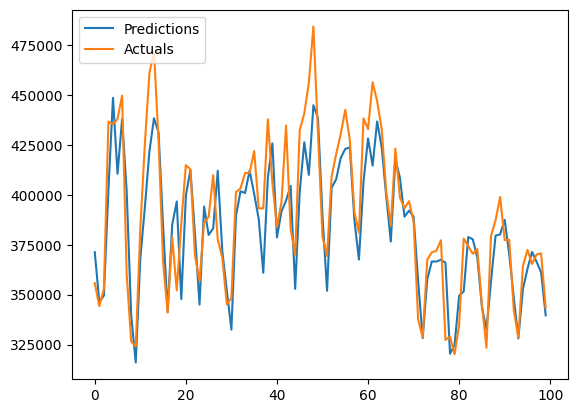

MAPE: 2.78%
RMSE: 15331.01
MAE : 10910.63


Predictions    Actuals
0     371274.00000  355814.96
1     346235.93750  344216.79
2     349520.28125  352812.68
3     402712.25000  436716.40
4     448593.09375  435360.14
...            ...        ...
1084  386895.40625  405457.46
1085  429048.53125  421027.63
1086  404663.90625  407376.71
1087  375941.75000  402263.51
1088  410425.62500  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model28 = load_model('model28.keras')

# print training metrics
predictions_plot(model28, X_train28, y_train28, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


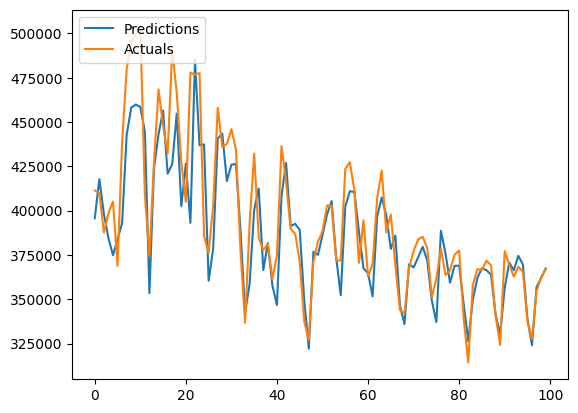

MAPE: 2.91%
RMSE: 16172.48
MAE : 11320.06


Predictions    Actuals
0    395730.65625  411339.27
1    417738.75000  409963.40
2    398201.40625  387672.63
3    384559.93750  398542.65
4    374839.68750  405159.36
..            ...        ...
353  363478.62500  360393.59
354  362181.81250  369325.03
355  380363.71875  371819.56
356  413664.03125  399427.25
357  408064.34375  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model28, X_test28, y_test28, 0, 100)

### Explore Recurrent Dropout ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data29 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train29, y_train29 = data29['train']
X_test29, y_test29 = data29['test']

# Initialise variables for input layer
i = X_train29.shape[1]
j = X_train29.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model29 = create_lstm_model(n_units=32, dropout=0.013, recurrent_dropout=0.013)

# create model checkpoint
cp29 = ModelCheckpoint('model29.keras', monitor='loss', save_best_only=True)

# compile model
model29.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0005, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history29 = model29.fit(X_train29, y_train29, epochs=100, batch_size=8, callbacks=[cp29])

Epoch 1/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0611 - root_mean_squared_error: 0.2370
Epoch 2/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0145 - root_mean_squared_error: 0.1202
Epoch 3/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0117 - root_mean_squared_error: 0.1080
Epoch 4/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0105 - root_mean_squared_error: 0.1024
Epoch 5/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994
Epoch 6/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0092 - root_mean_squared_error: 0.0955
Epoch 7/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965
Epoch 8/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - root_mean_squared_error: 0.0954
Epoch 9/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0091 - root_mean_squared_error: 0.0952
Epoch 10/100
137/137 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0090 - root_mean_s

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


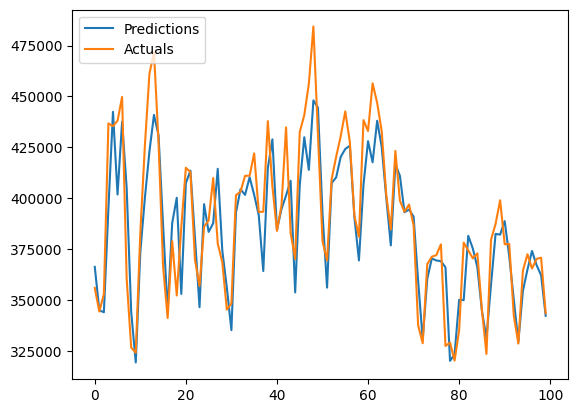

MAPE: 2.71%
RMSE: 15026.96
MAE : 10573.07


Predictions    Actuals
0     366204.53125  355814.96
1     344872.15625  344216.79
2     343893.75000  352812.68
3     395116.81250  436716.40
4     442393.40625  435360.14
...            ...        ...
1084  380416.46875  405457.46
1085  418085.03125  421027.63
1086  398193.53125  407376.71
1087  373558.84375  402263.51
1088  413895.65625  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model29 = load_model('model29.keras')

# print training metrics
predictions_plot(model29, X_train29, y_train29, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


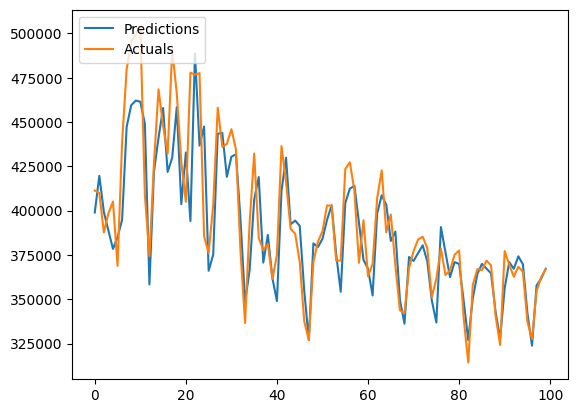

MAPE: 2.87%
RMSE: 15949.87
MAE : 11108.65


Predictions    Actuals
0    398934.71875  411339.27
1    419639.87500  409963.40
2    399213.46875  387672.63
3    388701.09375  398542.65
4    378406.75000  405159.36
..            ...        ...
353  363733.68750  360393.59
354  360232.81250  369325.03
355  369702.00000  371819.56
356  403205.46875  399427.25
357  394863.96875  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model29, X_test29, y_test29, 0, 100)

### Recurrent Optuna Trial w/ temp^2 ###

In [ ]:
# Create recurrent dropout and temp^2 Optuna study
study4 = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility
)

# Run study
study4.optimize(objective4, n_trials=100)

"study4 = optuna.create_study(\n    direction='minimize',\n    sampler=optuna.samplers.TPESampler(seed=42)  # Optional: set seed for reproducibility\n)\n\nstudy4.optimize(objective4, n_trials=100)"

In [ ]:
# Print results from best Optuna trial
print("Best trial:")
trial3 = study4.best_trial

print(f"  MAE: {trial4.value:.2f}")
print("  Params:")
for key, value in trial4.params.items():
    print(f"    {key}: {value}")

### Temp^2/Recurrent Dropout (Post Optuna) ###

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data30 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train30, y_train30 = data30['train']
X_test30, y_test30 = data30['test']

# Initialise variables for input layer
i = X_train30.shape[1]
j = X_train30.shape[2]

In [ ]:
# set seed
reset_seed()

# create model
model30 = create_lstm_model(n_units=64, dropout=0.00145, recurrent_dropout=0.3)

# create model checkpoint
cp30 = ModelCheckpoint('model30.keras', monitor='loss', save_best_only=True)

# compile model
model30.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history30 = model30.fit(X_train30, y_train30, epochs=100, batch_size=32, callbacks=[cp30])


Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0967 - root_mean_squared_error: 0.2988
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0105 - root_mean_squared_error: 0.1022
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0100 - root_mean_squared_error: 0.0999
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0099 - root_mean_squared_error: 0.0994
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0093 - root_mean_squared_error: 0.0965
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0092 - root_mean_squared_error: 0.0960
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0084 - root_mean_squared_error: 0.0919
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0083 - root_mean_squared_error: 0.0910
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0080 - root_mean_squared_error: 0.0893

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


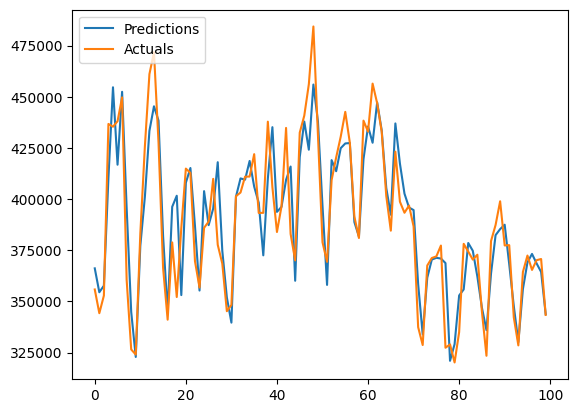

MAPE: 2.43%
RMSE: 13159.56
MAE : 9380.01


Predictions    Actuals
0     366137.15625  355814.96
1     354454.90625  344216.79
2     357672.37500  352812.68
3     410376.28125  436716.40
4     454642.59375  435360.14
...            ...        ...
1084  383894.96875  405457.46
1085  419585.78125  421027.63
1086  395818.31250  407376.71
1087  381854.87500  402263.51
1088  403308.15625  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model30 = load_model('model30.keras')

# print training metrics
predictions_plot(model30, X_train30, y_train30, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


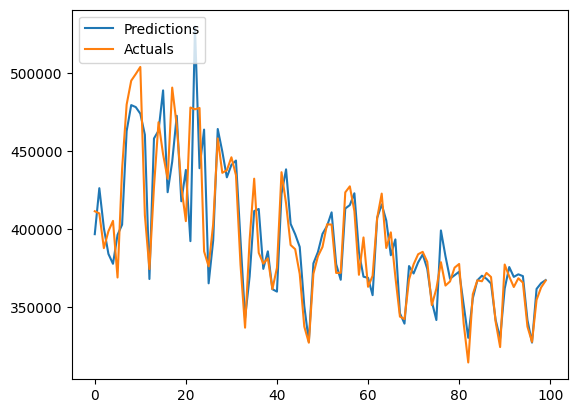

MAPE: 2.76%
RMSE: 15622.76
MAE : 10608.65


Predictions    Actuals
0    396631.65625  411339.27
1    426123.93750  409963.40
2    400492.34375  387672.63
3    383961.37500  398542.65
4    377638.12500  405159.36
..            ...        ...
353  359031.62500  360393.59
354  358034.84375  369325.03
355  379975.75000  371819.56
356  413305.15625  399427.25
357  399074.75000  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model30, X_test30, y_test30, 0, 100)

## 10. Test Attention ##

In [ ]:
@register_keras_serializable(package="Custom")
class SimpleAttention(Layer):
    def __init__(self, return_attention=False, **kwargs):
        super(SimpleAttention, self).__init__(**kwargs)
        self.return_attention = return_attention

    def build(self, input_shape):
        self.W = self.add_weight(name="att_weight",
                                 shape=(input_shape[-1], 1),
                                 initializer="normal",
                                 trainable=True)
        self.b = self.add_weight(name="att_bias",
                                 shape=(input_shape[1], 1),
                                 initializer="zeros",
                                 trainable=True)
        super(SimpleAttention, self).build(input_shape)

    def call(self, x):
        e = tf.keras.backend.tanh(tf.keras.backend.dot(x, self.W) + self.b)
        a = tf.keras.backend.softmax(e, axis=1)  # attention weights
        context = tf.reduce_sum(x * a, axis=1)
        if self.return_attention:
            return [context, a]   # return both if requested
        return context

    def get_config(self):
        config = super(SimpleAttention, self).get_config()
        config.update({"return_attention": self.return_attention})
        return config

In [ ]:
# Initialise preprocessor (create input matrix, scale, split)
preprocessor = TimeSeriesPreprocessorTT(seasonsWdWeDemandDF2, window_size=7, allow_overlap=False)
preprocessor.split()
preprocessor.scale()
data31 = preprocessor.get_model_inputs(target_col='sum_30_min_demand')

# Prepare splits for model run
X_train31, y_train31 = data31['train']
X_test31, y_test31 = data31['test']

# Initialise variables for input layer
i = X_train31.shape[1]
j = X_train31.shape[2]

In [ ]:
# set seed
reset_seed()

# create model

inputs = Input(shape=(i, j))  # i = window_size, j = features
lstm_out = LSTM(64, return_sequences=True,
                dropout=0.00145, recurrent_dropout=0.3, name='LSTM')(inputs)

context, att_weights = SimpleAttention(return_attention=True)(lstm_out)
dense = Dense(8, activation='tanh')(context)
outputs = Dense(1, activation='linear')(dense)

model31 = Model(inputs, outputs)

# create model checkpoint
cp31 = ModelCheckpoint('model31.keras', monitor='loss', save_best_only=True)

# compile model
model31.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.00311, clipnorm=1.0), metrics=[RootMeanSquaredError()])

# run model with defined train test validation splits, with associated callbacks
history31 = model31.fit(X_train31, y_train31, epochs=100, batch_size=32, callbacks=[cp31])

Epoch 1/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0398 - root_mean_squared_error: 0.1952
Epoch 2/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0150 - root_mean_squared_error: 0.1224
Epoch 3/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0140 - root_mean_squared_error: 0.1184
Epoch 4/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127 - root_mean_squared_error: 0.1128
Epoch 5/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0127 - root_mean_squared_error: 0.1125
Epoch 6/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - root_mean_squared_error: 0.1102
Epoch 7/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0121 - root_mean_squared_error: 0.1099
Epoch 8/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0119 - root_mean_squared_error: 0.1091
Epoch 9/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0118 - root_mean_squared_error: 0.1088
Epoch 10/100
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0117 - root_mean_squared_error: 0.1082

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


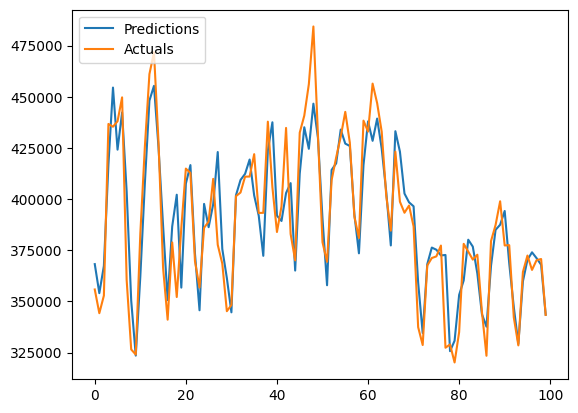

MAPE: 2.46%
RMSE: 13102.78
MAE : 9412.61


Predictions    Actuals
0     368210.46875  355814.96
1     354016.90625  344216.79
2     367321.46875  352812.68
3     416938.43750  436716.40
4     454498.56250  435360.14
...            ...        ...
1084  401171.34375  405457.46
1085  426966.53125  421027.63
1086  414629.46875  407376.71
1087  398420.09375  402263.51
1088  417477.43750  405023.08

[1089 rows x 2 columns]

In [ ]:
# load model from best checkpoint
model31 = load_model('model31.keras')

# print training metrics
predictions_plot(model31, X_train31, y_train31, 0, 100)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


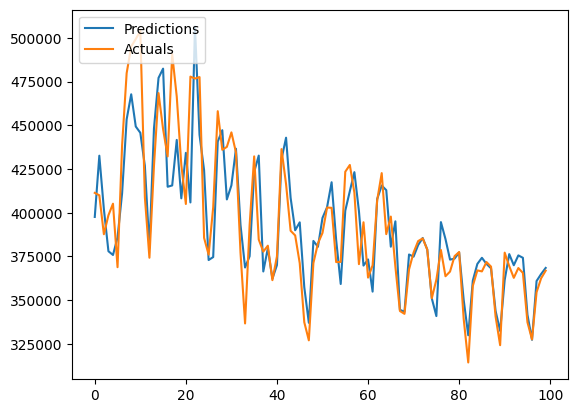

MAPE: 3.24%
RMSE: 17409.29
MAE : 12424.50


Predictions    Actuals
0    397576.28125  411339.27
1    432606.37500  409963.40
2    402021.09375  387672.63
3    377967.43750  398542.65
4    375825.31250  405159.36
..            ...        ...
353  379108.43750  360393.59
354  370291.28125  369325.03
355  401492.96875  371819.56
356  431281.53125  399427.25
357  408380.90625  408178.89

[358 rows x 2 columns]

In [ ]:
# print testing metrics
predictions_plot(model31, X_test31, y_test31, 0, 100)

## 11. Feature Importance Analysis & Results ##

In [ ]:
'''
Use SHAP Analysis Package to report on the feature importance ranking for
features in the final optimised model
'''

# Flatten data
X_train_flat = X_train30.reshape(X_train30.shape[0], -1)  # (n_samples, 98)
X_test_flat  = X_test30.reshape(X_test30.shape[0], -1)

# Prediction function definition
def predict_fn(x):
    x_reshaped = x.reshape(x.shape[0], 7, 14)
    return model30.predict(x_reshaped, verbose=0)

# Set background and test subsets
background = X_train_flat[:200]
X_explain  = X_test_flat[:100]

# Initialise Kernel Explainer
explainer = shap.KernelExplainer(predict_fn, background)
shap_values = explainer.shap_values(X_explain)

# Revert to original shape
shap_values = np.array(shap_values).reshape(len(X_explain), 7, 14)

# Average importance over samples
feature_importance = np.mean(np.abs(shap_values), axis=(0,1))

# Extract feature names for plot
feature_names = seasonsWdWeDemandDF2.columns.tolist()

# Plot bar chart (in order of importance)
sorted_idx = np.argsort(feature_importance)[::-1]

plt.figure(figsize=(8,6))
plt.barh([feature_names[i] for i in sorted_idx], feature_importance[sorted_idx])
plt.gca().invert_yaxis()
plt.xlabel("Feature Importance")
plt.title("Global Feature Importance (averaged across timesteps & samples)")
plt.tight_layout()
plt.savefig("LSTM_feat_imp.png")
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

### Print Final Results ###

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Plot saved to final_predictions.png


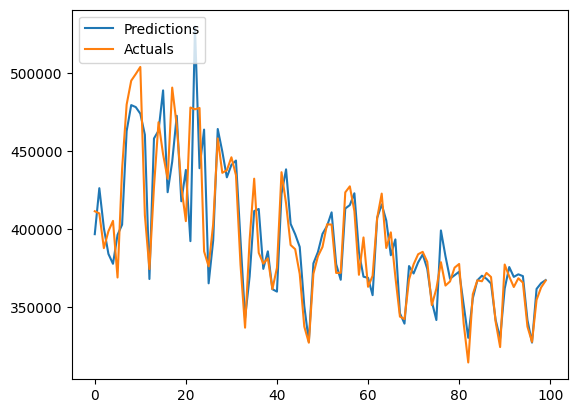

MAPE: 2.76%
RMSE: 15622.76
MAE : 10608.65


Predictions    Actuals
0    396631.65625  411339.27
1    426123.93750  409963.40
2    400492.34375  387672.63
3    383961.37500  398542.65
4    377638.12500  405159.36
..            ...        ...
353  359031.62500  360393.59
354  358034.84375  369325.03
355  379975.75000  371819.56
356  413305.15625  399427.25
357  399074.75000  408178.89

[358 rows x 2 columns]

In [ ]:
## Save Test Predictions for optimal model to file
predictions_plot(model30, X_test30, y_test30, 0, 100, save_path='final_predictions.png')